In [1]:
import eli5
import numpy as np
import pandas as pd
from IPython.display import display
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from eli5.sklearn import PermutationImportance
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns


import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader

import warnings
warnings.filterwarnings("ignore")

In [2]:
def preprocessing(X_train, X_test, preprocessing_type = "normalization"):
    
    if preprocessing_type == "normalization":
        scaler = StandardScaler()
    else:
        scaler = MinMaxScaler()
        
    scaler.fit(X_train) 
    
    X_train = scaler.transform(X_train)

    X_test = scaler.transform(X_test)  
    
    return X_train, X_test, scaler

In [3]:
def display_correlation_matrix(data):
    
    corr_matrix = data.corr()
    
    display(corr_matrix)

    mask = np.triu(np.ones_like(corr_matrix, dtype=np.bool))

    f, ax = plt.subplots(figsize=(11, 9))

    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [4]:
def drop_highly_correlated_features(data, threshold = 0.99):

    corr_matrix = data.corr().abs()

    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    
    print("Features to drop for Threshold " + str(threshold), to_drop)
    
    data.drop(data[to_drop], axis = 1, inplace = True)
    
    return data

In [5]:
def display_feature_importance(model, features, labels):
    print("Features: ", features.columns.values)
    importance = PermutationImportance(model).fit(features, y_test)
    return importance

In [6]:
class HousePriceDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__ (self, index):
        x = self.features[index]
        y = self.labels[index]
        
        return x, y

In [7]:
class NeuralNetwork(nn.Module):
    
    def __init__(self, m_hidden_layers, n_input, n_hidden, n_output, network_type = "classification"):
        super().__init__()
        
        self.m_hidden_layers = m_hidden_layers
        
        self.input_layer = nn.Linear(n_input, n_hidden)
    
        self.hidden_layer = nn.Linear(n_hidden, n_hidden)
        
        self.output_layer = nn.Linear(n_hidden, n_output)
        
        self.bn  = nn.BatchNorm1d(n_hidden)
        
        self.activation = nn.LeakyReLU()
        
        assert network_type in ["classification", "regression"]
        
        self.network_type = network_type
        
        self.dropout = nn.Dropout(p = 0.2)
        
    def forward(self, x):
        
        # Use dropout only for regression
        
        if self.network_type == "regression":
            
            x = self.dropout(self.activation(self.input_layer(x)))

            for step in range(self.m_hidden_layers):
                x = self.dropout(self.activation(self.bn(self.hidden_layer(x))))

            x = self.output_layer(x)
        
        else:
            
            x = self.activation(self.input_layer(x))

            for step in range(self.m_hidden_layers):
                x = self.activation(self.bn(self.hidden_layer(x)))

            x = self.output_layer(x)
        
        return x

In [8]:
from scipy.optimize import minimize
from functools import partial

class OptimizedRounder(object):
    # https://www.kaggle.com/naveenasaithambi/optimizedrounder-improved
    def __init__(self):
        self.coef = 0

    def loss(self, coef, samples, labels):
        """
        Get loss according to
        using current coefficients
        
        :param coef: A list of coefficients that will be used for rounding
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        
        
        limit = [-np.inf] + list(np.sort(coef)) + [np.inf]

        opt_labels = pd.cut(samples, limit, labels = [0, 1, 2, 3, 4])

        return -accuracy_score(opt_labels, labels) 


    
    def fit(self, X, y):
        """
        Optimize rounding thresholds
        
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        loss_partial = partial(self.loss, samples = X, labels=y)
        
        initial_coef = [1, 2, 3, 4]

        self.coef = minimize(loss_partial, initial_coef, method='Nelder-Mead')
        


    def predict(self, X):
        """
        Make predictions with specified thresholds
        
        :param X: The raw predictions
        :param coef: A list of coefficients that will be used for rounding
        """
        
        limit = [-np.inf] + list(np.sort(self.coef['x'])) + [np.inf]

        return pd.cut(X, limit, labels = [0, 1, 2, 3, 4])
    
    def coefficients(self):
        return self.coef['x']

In [9]:
def RMSLELoss(y_true, y_hat):
    return torch.abs(torch.sqrt(torch.mean((torch.log(y_true + 1) - torch.log(y_hat.float() + 1)) ** 2)))

In [10]:
def RMSLELoss_for_numpy(h, y): 
    """
    Compute the Root Mean Squared Log Error for hypthesis h and targets y
    
    Args:
        h - numpy array containing predictions with shape (n_samples, n_targets)
        y - numpy array containing targets with shape (n_samples, n_targets)
    """
    return np.sqrt(np.square(np.log(h + 1) - np.log(y + 1)).mean())

# Reading the dataset
- Will separate the labels from features
- And will map the labels from (1 - 5) to (0 - 4) for convenience in the softmax layer

In [11]:
data = pd.read_csv("Bucharest_HousePriceDataset.csv")

display(data.head(n = 10))

features = data.drop(['Scor'], axis = 1, inplace = False)

labels   = data["Scor"].apply(lambda x : x - 1)

,Nr Camere,Suprafata,Etaj,Total Etaje,Sector,Scor,Pret
0,4,108.00,2,3,4,5,83000
1,1,41.00,1,8,1,1,39900
2,3,63.52,1,3,2,3,84900
3,1,33.00,3,10,5,1,45500
4,2,62.00,5,9,5,5,54900
5,3,132.00,2,6,1,2,349990
6,2,49.00,6,6,6,4,36500
7,3,92.00,4,8,2,2,119000
8,3,68.00,3,5,4,5,67500
9,3,110.00,1,2,1,1,133000


# Visualize the correlation matrix 
- Drop higgly correlated features (if necessary)


,Nr Camere,Suprafata,Etaj,Total Etaje,Sector,Scor,Pret
Nr Camere,1.000000,0.807278,0.066427,-0.012815,-0.183737,-0.215591,0.635789
Suprafata,0.807278,1.000000,0.060527,-0.041367,-0.240274,-0.299838,0.807414
Etaj,0.066427,0.060527,1.000000,0.559217,0.061581,0.027381,0.038719
Total Etaje,-0.012815,-0.041367,0.559217,1.000000,0.103467,0.036039,0.006063
Sector,-0.183737,-0.240274,0.061581,0.103467,1.000000,0.577602,-0.409052
Scor,-0.215591,-0.299838,0.027381,0.036039,0.577602,1.000000,-0.531826
Pret,0.635789,0.807414,0.038719,0.006063,-0.409052,-0.531826,1.000000


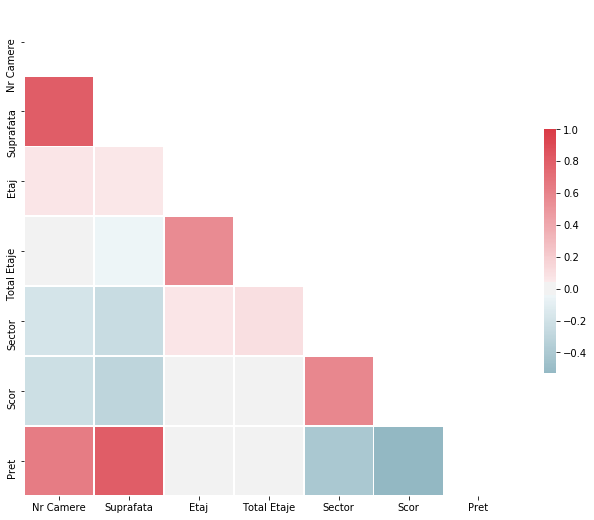

In [12]:
display_correlation_matrix(data)

In [13]:
data = drop_highly_correlated_features(data)

Features to drop for Threshold 0.99 []


# Splitting Data Methodology
- First step: Will get a hold out set (train set - test set: 0.8 - 0.2)
- Second step: Will use a cross-validation with 5 fold (4 training fold - 1 validation fold)

- As note: This Methodology is typically used in deep learning for large datasets, this concludes that for our 3529 samples may not be fitted


In [14]:
X_train, X_test, y_train, y_test = train_test_split(features, labels.values, train_size = 0.9, random_state = 42)

# Lets get a baseline model without cross-validation

- To get a sense of the problem will display the accuracy and the feature importance of the model



In [15]:
model = RandomForestClassifier(n_estimators = 100)

model.fit(X_train, y_train)

y_predict = model.predict(X_test)

accuracy = accuracy_score(y_predict, y_test)

print("Baseline Random Forest: ", accuracy)

importance = display_feature_importance(model, X_test, y_test)

eli5.show_weights(importance)

Baseline Random Forest:  0.7818696883852692
Features:  ['Nr Camere' 'Suprafata' 'Etaj' 'Total Etaje' 'Sector' 'Pret']


Weight,Feature
0.4448 ± 0.0424,x4
0.2425 ± 0.0223,x5
0.0555 ± 0.0257,x1
0.0544 ± 0.0181,x3
0.0249 ± 0.0264,x2
0.0057 ± 0.0238,x0



# Lets do the same for a neural network from sklearn

In [16]:
model = MLPClassifier(hidden_layer_sizes = (10, 10, 10, 10))

model.fit(X_train, y_train)

y_predict = model.predict(X_test)

accuracy = accuracy_score(y_predict, y_test)

print("Baseline Neural Network: ", accuracy)

Baseline Neural Network:  0.24929178470254956





# Something went wrong...
- As you can see the results are quite disappointing, and the reason for this difference in each model accuracy is that tree base models (such as Random Forrest) are invariant to features scaling, but the neural networks are not

# Lets use a mean normalization over data and retry the experiment 

In [17]:
X_train_scaled, X_test_scaled, _ = preprocessing(X_train, X_test)
print(len(X_train_scaled))
print(len(X_test_scaled))

3176
353


In [18]:
model = MLPClassifier(hidden_layer_sizes = (12, 12, 12, 12, 12), max_iter = 500)

model.fit(X_train_scaled, y_train)

y_predict = model.predict(X_test_scaled)

accuracy = accuracy_score(y_predict, y_test)

print("Baseline Neural Network: ", accuracy)

Baseline Neural Network:  0.7563739376770539


# That's much better, now lets do that in Pytorch
- But now with cross-validation 

Model for Fold: 0
Epoch: 1/100..  Training Loss: 1.076..  Test Loss: 0.804..  Test Accuracy: 0.692
Epoch: 2/100..  Training Loss: 0.849..  Test Loss: 0.735..  Test Accuracy: 0.686
Epoch: 3/100..  Training Loss: 0.792..  Test Loss: 0.652..  Test Accuracy: 0.728
Epoch: 4/100..  Training Loss: 0.772..  Test Loss: 0.600..  Test Accuracy: 0.729
Epoch: 5/100..  Training Loss: 0.768..  Test Loss: 0.677..  Test Accuracy: 0.715
Epoch: 6/100..  Training Loss: 0.764..  Test Loss: 0.630..  Test Accuracy: 0.715
Epoch: 7/100..  Training Loss: 0.753..  Test Loss: 0.617..  Test Accuracy: 0.738
Epoch: 8/100..  Training Loss: 0.717..  Test Loss: 0.592..  Test Accuracy: 0.729
Epoch: 9/100..  Training Loss: 0.702..  Test Loss: 0.573..  Test Accuracy: 0.741
Epoch: 10/100..  Training Loss: 0.741..  Test Loss: 0.590..  Test Accuracy: 0.750
Epoch: 11/100..  Training Loss: 0.696..  Test Loss: 0.599..  Test Accuracy: 0.707
Epoch: 12/100..  Training Loss: 0.671..  Test Loss: 0.604..  Test Accuracy: 0.720
Epoch: 

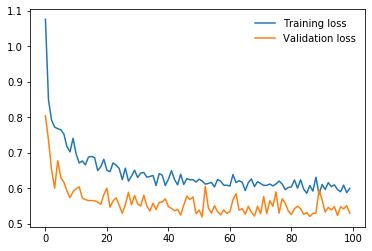

Model for Fold: 1
Epoch: 1/100..  Training Loss: 1.148..  Test Loss: 0.965..  Test Accuracy: 0.616
Epoch: 2/100..  Training Loss: 0.925..  Test Loss: 0.805..  Test Accuracy: 0.671
Epoch: 3/100..  Training Loss: 0.786..  Test Loss: 0.654..  Test Accuracy: 0.709
Epoch: 4/100..  Training Loss: 0.753..  Test Loss: 0.608..  Test Accuracy: 0.738
Epoch: 5/100..  Training Loss: 0.737..  Test Loss: 0.647..  Test Accuracy: 0.690
Epoch: 6/100..  Training Loss: 0.734..  Test Loss: 0.642..  Test Accuracy: 0.689
Epoch: 7/100..  Training Loss: 0.695..  Test Loss: 0.619..  Test Accuracy: 0.717
Epoch: 8/100..  Training Loss: 0.720..  Test Loss: 0.637..  Test Accuracy: 0.739
Epoch: 9/100..  Training Loss: 0.701..  Test Loss: 0.625..  Test Accuracy: 0.731
Epoch: 10/100..  Training Loss: 0.690..  Test Loss: 0.631..  Test Accuracy: 0.729
Epoch: 11/100..  Training Loss: 0.667..  Test Loss: 0.624..  Test Accuracy: 0.717
Epoch: 12/100..  Training Loss: 0.679..  Test Loss: 0.585..  Test Accuracy: 0.729
Epoch: 

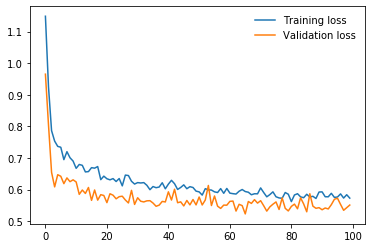

Model for Fold: 2
Epoch: 1/100..  Training Loss: 1.175..  Test Loss: 1.054..  Test Accuracy: 0.528
Epoch: 2/100..  Training Loss: 0.988..  Test Loss: 0.879..  Test Accuracy: 0.682
Epoch: 3/100..  Training Loss: 0.854..  Test Loss: 0.789..  Test Accuracy: 0.678
Epoch: 4/100..  Training Loss: 0.734..  Test Loss: 0.695..  Test Accuracy: 0.729
Epoch: 5/100..  Training Loss: 0.740..  Test Loss: 0.684..  Test Accuracy: 0.712
Epoch: 6/100..  Training Loss: 0.725..  Test Loss: 0.678..  Test Accuracy: 0.694
Epoch: 7/100..  Training Loss: 0.708..  Test Loss: 0.670..  Test Accuracy: 0.712
Epoch: 8/100..  Training Loss: 0.709..  Test Loss: 0.654..  Test Accuracy: 0.732
Epoch: 9/100..  Training Loss: 0.680..  Test Loss: 0.661..  Test Accuracy: 0.709
Epoch: 10/100..  Training Loss: 0.688..  Test Loss: 0.631..  Test Accuracy: 0.716
Epoch: 11/100..  Training Loss: 0.654..  Test Loss: 0.623..  Test Accuracy: 0.715
Epoch: 12/100..  Training Loss: 0.683..  Test Loss: 0.675..  Test Accuracy: 0.696
Epoch: 

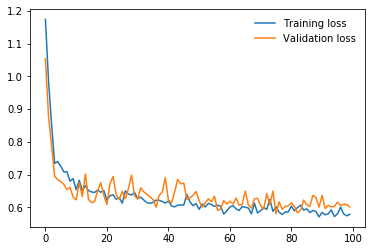

Model for Fold: 3
Epoch: 1/100..  Training Loss: 1.169..  Test Loss: 0.993..  Test Accuracy: 0.565
Epoch: 2/100..  Training Loss: 0.921..  Test Loss: 0.721..  Test Accuracy: 0.684
Epoch: 3/100..  Training Loss: 0.814..  Test Loss: 0.689..  Test Accuracy: 0.706
Epoch: 4/100..  Training Loss: 0.738..  Test Loss: 0.689..  Test Accuracy: 0.669
Epoch: 5/100..  Training Loss: 0.763..  Test Loss: 0.652..  Test Accuracy: 0.700
Epoch: 6/100..  Training Loss: 0.704..  Test Loss: 0.624..  Test Accuracy: 0.743
Epoch: 7/100..  Training Loss: 0.706..  Test Loss: 0.635..  Test Accuracy: 0.715
Epoch: 8/100..  Training Loss: 0.669..  Test Loss: 0.642..  Test Accuracy: 0.724
Epoch: 9/100..  Training Loss: 0.718..  Test Loss: 0.656..  Test Accuracy: 0.723
Epoch: 10/100..  Training Loss: 0.669..  Test Loss: 0.634..  Test Accuracy: 0.729
Epoch: 11/100..  Training Loss: 0.677..  Test Loss: 0.619..  Test Accuracy: 0.753
Epoch: 12/100..  Training Loss: 0.688..  Test Loss: 0.640..  Test Accuracy: 0.707
Epoch: 

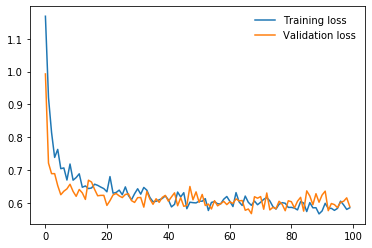

Model for Fold: 4
Epoch: 1/100..  Training Loss: 1.156..  Test Loss: 1.006..  Test Accuracy: 0.578
Epoch: 2/100..  Training Loss: 0.869..  Test Loss: 0.679..  Test Accuracy: 0.710
Epoch: 3/100..  Training Loss: 0.720..  Test Loss: 0.620..  Test Accuracy: 0.711
Epoch: 4/100..  Training Loss: 0.696..  Test Loss: 0.599..  Test Accuracy: 0.733
Epoch: 5/100..  Training Loss: 0.680..  Test Loss: 0.628..  Test Accuracy: 0.705
Epoch: 6/100..  Training Loss: 0.698..  Test Loss: 0.624..  Test Accuracy: 0.710
Epoch: 7/100..  Training Loss: 0.662..  Test Loss: 0.612..  Test Accuracy: 0.712
Epoch: 8/100..  Training Loss: 0.652..  Test Loss: 0.632..  Test Accuracy: 0.699
Epoch: 9/100..  Training Loss: 0.657..  Test Loss: 0.593..  Test Accuracy: 0.719
Epoch: 10/100..  Training Loss: 0.648..  Test Loss: 0.632..  Test Accuracy: 0.716
Epoch: 11/100..  Training Loss: 0.669..  Test Loss: 0.626..  Test Accuracy: 0.702
Epoch: 12/100..  Training Loss: 0.647..  Test Loss: 0.619..  Test Accuracy: 0.697
Epoch: 

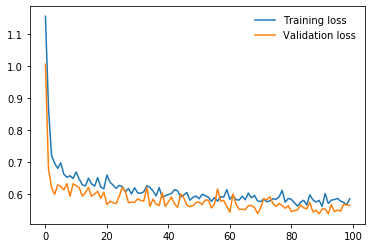

In [19]:
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
cv = cv.split(X_train_scaled, y_train)

m_hidden_layers = 1
n_input = 6
n_hidden = 12
n_output = 5
network_type = "classification"

bs = 16

device = "cuda:0"

models = []
max_scores = []
for fold, (train_idx, val_idx) in enumerate(cv):
    print("Model for Fold: " + str(fold))

    train_set, train_labels = X_train_scaled[train_idx], y_train[train_idx]
    valid_set, valid_labels = X_train_scaled[val_idx], y_train[val_idx]
    
    trainset = HousePriceDataset(train_set, train_labels)
    trainloader = DataLoader(trainset, batch_size = bs, shuffle = True)

    validset = HousePriceDataset(valid_set, valid_labels)
    validloader = DataLoader(validset, batch_size = bs, shuffle = True)
    
    model = NeuralNetwork(m_hidden_layers, n_input, n_hidden, n_output, network_type).to(device)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.02)

    epochs = 100
    
    train_losses, test_losses = [], []
    
    best_accuracy = 0
    best_model_checkpoint = None
    
    for e in range(epochs):
        running_loss = 0

    
        for features, labels in trainloader:
            model.train()
            features = features.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()

            log_ps = model(features.float())

            loss = criterion(log_ps, labels)
        
            loss.backward()

            optimizer.step()

            running_loss += loss.item()

        else:
            test_loss = 0
            accuracy = 0

            
            with torch.no_grad():
                for features, labels in validloader:
                    
                    model.eval()
                    features = features.to(device)
                    labels = labels.to(device)

                    log_ps = model(features.float())

                    test_loss += criterion(log_ps, labels)

                    top_p, top_class = log_ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor))
                    
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(validloader))
            
            if (accuracy / len(validloader)) > best_accuracy:
                best_accuracy = accuracy/len(validloader)
                best_model_checkpoint = model
            
            print("Epoch: {}/{}.. ".format(e+1, epochs),
                  "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
                  "Test Loss: {:.3f}.. ".format(test_loss/len(validloader)),
                  "Test Accuracy: {:.3f}".format(accuracy/len(validloader)))
            
    plt.plot(train_losses, label='Training loss')
    plt.plot(test_losses, label='Validation loss')
    plt.legend(frameon=False)
    plt.show()

    models.append(best_model_checkpoint)
    max_scores.append(best_accuracy)

In [20]:
index = 0
for score in max_scores:
    print("Fold: {}, with score: {:.3f}" .format(index, score.item()))
    index += 1

Fold: 0, with score: 0.769
Fold: 1, with score: 0.755
Fold: 2, with score: 0.759
Fold: 3, with score: 0.764
Fold: 4, with score: 0.769


In [21]:
evalset = HousePriceDataset(X_test_scaled, y_test)
loader  = DataLoader(evalset, batch_size=len(X_test_scaled))

with torch.no_grad():
    for features, labels in loader: 
        features = features.to(device)
        labels = labels.to(device)
        
        logs = 0
        index = 0
        for model in models:
            model.eval()
            log_ps = model(features.float())
            logs += (log_ps * max_scores[index]) / sum(max_scores)
            index += 1
        
        logs = logs / len(models)
        
        ps = torch.exp(logs)
            
        _, indices = torch.max(ps, dim = 1)
        
y_predict = indices.cpu().numpy()
print("Final Model Testing Score: " + str(accuracy_score(y_predict, y_test)))

Final Model Testing Score: 0.7393767705382436


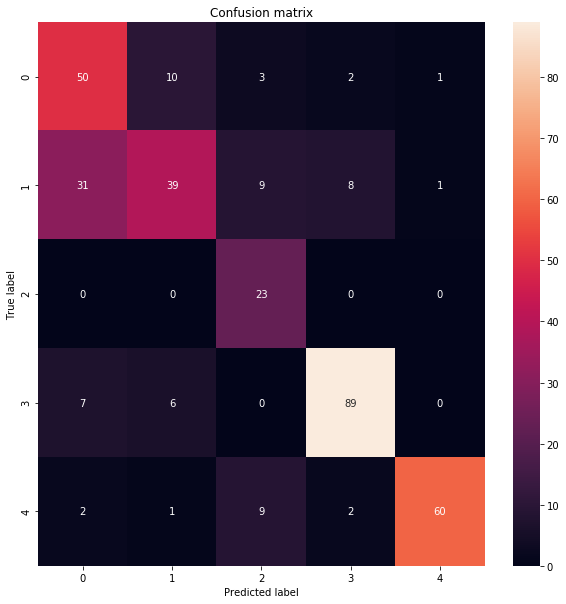

In [22]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_predict)
plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show();

# Regression Part 
- The differences will be: 
1. The loss function: Mean Squared Error
2. Number of neurons in the final layer will one (a continuous value)
3. Will need to find some optim thresholds to map that continuous value in the discrete labels

Model for Fold: 0
Epoch: 1/100..  Training Loss: 4.495..  Test Loss: 4.607.. 
Epoch: 2/100..  Training Loss: 4.071..  Test Loss: 4.090.. 
Epoch: 3/100..  Training Loss: 3.662..  Test Loss: 3.699.. 
Epoch: 4/100..  Training Loss: 3.323..  Test Loss: 3.252.. 
Epoch: 5/100..  Training Loss: 3.039..  Test Loss: 2.991.. 
Epoch: 6/100..  Training Loss: 2.849..  Test Loss: 2.761.. 
Epoch: 7/100..  Training Loss: 2.699..  Test Loss: 2.622.. 
Epoch: 8/100..  Training Loss: 2.599..  Test Loss: 2.517.. 
Epoch: 9/100..  Training Loss: 2.548..  Test Loss: 2.439.. 
Epoch: 10/100..  Training Loss: 2.499..  Test Loss: 2.351.. 
Epoch: 11/100..  Training Loss: 2.469..  Test Loss: 2.314.. 
Epoch: 12/100..  Training Loss: 2.444..  Test Loss: 2.274.. 
Epoch: 13/100..  Training Loss: 2.429..  Test Loss: 2.252.. 
Epoch: 14/100..  Training Loss: 2.418..  Test Loss: 2.252.. 
Epoch: 15/100..  Training Loss: 2.403..  Test Loss: 2.236.. 
Epoch: 16/100..  Training Loss: 2.380..  Test Loss: 2.230.. 
Epoch: 17/100..

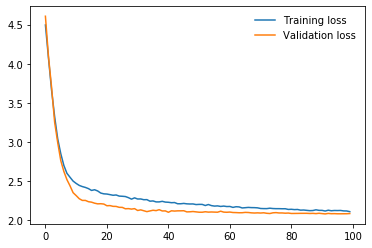

Model for Fold: 1
Epoch: 1/100..  Training Loss: 7.544..  Test Loss: 6.710.. 
Epoch: 2/100..  Training Loss: 6.846..  Test Loss: 6.247.. 
Epoch: 3/100..  Training Loss: 6.249..  Test Loss: 5.778.. 
Epoch: 4/100..  Training Loss: 5.776..  Test Loss: 5.378.. 
Epoch: 5/100..  Training Loss: 5.339..  Test Loss: 5.081.. 
Epoch: 6/100..  Training Loss: 4.932..  Test Loss: 4.746.. 
Epoch: 7/100..  Training Loss: 4.568..  Test Loss: 4.412.. 
Epoch: 8/100..  Training Loss: 4.276..  Test Loss: 4.120.. 
Epoch: 9/100..  Training Loss: 3.998..  Test Loss: 3.878.. 
Epoch: 10/100..  Training Loss: 3.754..  Test Loss: 3.674.. 
Epoch: 11/100..  Training Loss: 3.549..  Test Loss: 3.480.. 
Epoch: 12/100..  Training Loss: 3.375..  Test Loss: 3.346.. 
Epoch: 13/100..  Training Loss: 3.264..  Test Loss: 3.209.. 
Epoch: 14/100..  Training Loss: 3.165..  Test Loss: 3.088.. 
Epoch: 15/100..  Training Loss: 3.052..  Test Loss: 2.999.. 
Epoch: 16/100..  Training Loss: 2.971..  Test Loss: 2.930.. 
Epoch: 17/100..

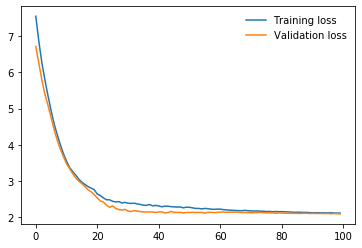

Model for Fold: 2
Epoch: 1/100..  Training Loss: 7.046..  Test Loss: 6.696.. 
Epoch: 2/100..  Training Loss: 6.366..  Test Loss: 6.079.. 
Epoch: 3/100..  Training Loss: 5.820..  Test Loss: 5.594.. 
Epoch: 4/100..  Training Loss: 5.280..  Test Loss: 5.074.. 
Epoch: 5/100..  Training Loss: 4.790..  Test Loss: 4.602.. 
Epoch: 6/100..  Training Loss: 4.322..  Test Loss: 4.216.. 
Epoch: 7/100..  Training Loss: 3.965..  Test Loss: 3.792.. 
Epoch: 8/100..  Training Loss: 3.678..  Test Loss: 3.507.. 
Epoch: 9/100..  Training Loss: 3.478..  Test Loss: 3.248.. 
Epoch: 10/100..  Training Loss: 3.215..  Test Loss: 2.993.. 
Epoch: 11/100..  Training Loss: 3.146..  Test Loss: 2.852.. 
Epoch: 12/100..  Training Loss: 3.021..  Test Loss: 2.717.. 
Epoch: 13/100..  Training Loss: 2.934..  Test Loss: 2.609.. 
Epoch: 14/100..  Training Loss: 2.817..  Test Loss: 2.534.. 
Epoch: 15/100..  Training Loss: 2.811..  Test Loss: 2.482.. 
Epoch: 16/100..  Training Loss: 2.806..  Test Loss: 2.428.. 
Epoch: 17/100..

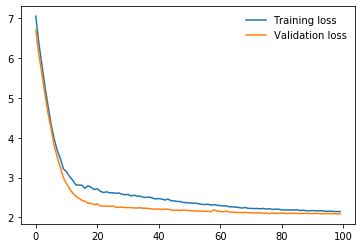

Model for Fold: 3
Epoch: 1/100..  Training Loss: 3.998..  Test Loss: 3.924.. 
Epoch: 2/100..  Training Loss: 3.669..  Test Loss: 3.609.. 
Epoch: 3/100..  Training Loss: 3.371..  Test Loss: 3.367.. 
Epoch: 4/100..  Training Loss: 3.164..  Test Loss: 3.119.. 
Epoch: 5/100..  Training Loss: 2.955..  Test Loss: 2.975.. 
Epoch: 6/100..  Training Loss: 2.862..  Test Loss: 2.800.. 
Epoch: 7/100..  Training Loss: 2.720..  Test Loss: 2.683.. 
Epoch: 8/100..  Training Loss: 2.646..  Test Loss: 2.581.. 
Epoch: 9/100..  Training Loss: 2.634..  Test Loss: 2.492.. 
Epoch: 10/100..  Training Loss: 2.539..  Test Loss: 2.431.. 
Epoch: 11/100..  Training Loss: 2.527..  Test Loss: 2.361.. 
Epoch: 12/100..  Training Loss: 2.434..  Test Loss: 2.279.. 
Epoch: 13/100..  Training Loss: 2.389..  Test Loss: 2.233.. 
Epoch: 14/100..  Training Loss: 2.368..  Test Loss: 2.194.. 
Epoch: 15/100..  Training Loss: 2.391..  Test Loss: 2.169.. 
Epoch: 16/100..  Training Loss: 2.333..  Test Loss: 2.169.. 
Epoch: 17/100..

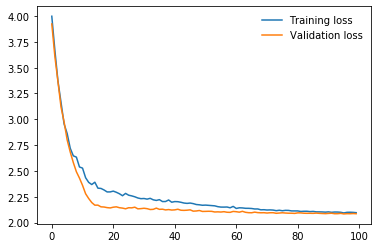

Model for Fold: 4
Epoch: 1/100..  Training Loss: 5.080..  Test Loss: 5.044.. 
Epoch: 2/100..  Training Loss: 4.656..  Test Loss: 4.513.. 
Epoch: 3/100..  Training Loss: 4.240..  Test Loss: 4.146.. 
Epoch: 4/100..  Training Loss: 3.892..  Test Loss: 3.902.. 
Epoch: 5/100..  Training Loss: 3.617..  Test Loss: 3.571.. 
Epoch: 6/100..  Training Loss: 3.313..  Test Loss: 3.324.. 
Epoch: 7/100..  Training Loss: 3.083..  Test Loss: 3.101.. 
Epoch: 8/100..  Training Loss: 2.962..  Test Loss: 2.894.. 
Epoch: 9/100..  Training Loss: 2.818..  Test Loss: 2.742.. 
Epoch: 10/100..  Training Loss: 2.724..  Test Loss: 2.639.. 
Epoch: 11/100..  Training Loss: 2.612..  Test Loss: 2.557.. 
Epoch: 12/100..  Training Loss: 2.592..  Test Loss: 2.494.. 
Epoch: 13/100..  Training Loss: 2.559..  Test Loss: 2.436.. 
Epoch: 14/100..  Training Loss: 2.514..  Test Loss: 2.412.. 
Epoch: 15/100..  Training Loss: 2.494..  Test Loss: 2.354.. 
Epoch: 16/100..  Training Loss: 2.453..  Test Loss: 2.363.. 
Epoch: 17/100..

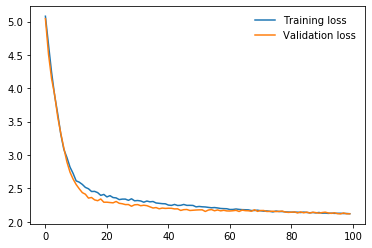

In [23]:
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
cv = cv.split(X_train_scaled, y_train)

m_hidden_layers = 1

n_input = 6
n_hidden = 4
n_output = 1

bs = 64
device = "cuda:0"
epochs = 100

network_type = "regression"

regressors = []

for fold, (train_idx, val_idx) in enumerate(cv):
    print("Model for Fold: " + str(fold))

    train_set, train_labels = X_train_scaled[train_idx], y_train[train_idx]
    valid_set, valid_labels = X_train_scaled[val_idx], y_train[val_idx]
    
    trainset = HousePriceDataset(train_set, train_labels)
    trainloader = DataLoader(trainset, batch_size = bs, shuffle = True)

    validset = HousePriceDataset(valid_set, valid_labels)
    validloader = DataLoader(validset, batch_size = bs, shuffle = True)

    regressor = NeuralNetwork(m_hidden_layers, n_input, n_hidden, n_output, network_type).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(regressor.parameters(), lr=0.001)
    
    train_losses, test_losses = [], []
    for e in range(epochs):
        running_loss = 0

        for features, labels in trainloader:

            regressor.train()

            features = features.to(device)

            labels = labels.to(device)

            optimizer.zero_grad()

            output = regressor(features.float())

            loss = criterion(output, labels.float())

            loss.backward()

            optimizer.step()

            running_loss += loss.item()

        else:
            test_loss = 0

            with torch.no_grad():
                for features, labels in validloader:
                    regressor.eval()

                    features = features.to(device)
                    labels = labels.to(device)

                    output = regressor(features.float())

                    test_loss += criterion(output, labels)


            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(validloader))

            print("Epoch: {}/{}.. ".format(e+1, epochs),
                  "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
                  "Test Loss: {:.3f}.. ".format(test_loss/len(validloader)))
        
    plt.plot(train_losses, label='Training loss')
    plt.plot(test_losses, label='Validation loss')
    plt.legend(frameon=False)
    plt.show()
    
    regressors.append(regressor)

# The regression problem 
- As you will see below, my regression model has a tendency to predict values close to the mean (labels are from 0 to 4)
- The reason for that could be that the label distribution for the "Scor" feature is a bimodal distribution, this could represent that my model is uncertain what to predict between (0 or 1) and (3, 4) so for minimizing the loss he chooses the center value, in this case (2)

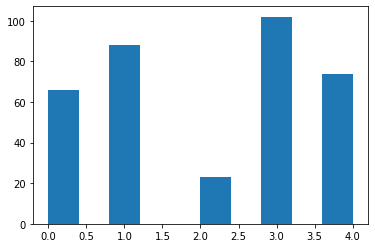

In [24]:
plt.hist(y_test)
plt.show()

In [25]:
evalset = HousePriceDataset(X_test_scaled, y_test)
loader  = DataLoader(evalset, batch_size=len(X_test_scaled))

with torch.no_grad():
    for features, labels in loader: 
        features = features.to(device)
        labels = labels.to(device)
    
        
        outputs = 0
        for regressor in regressors:
            output = regressor(features.float())
            outputs += output
        
        outputs = outputs / len(models)
        
Ypred = outputs.cpu().numpy().squeeze()
Yreal = labels.cpu().numpy()

print("Loss on Testing Data:", criterion(outputs, labels).item())

print("Lets see predictions")
print(Ypred)

optR = OptimizedRounder()

optR.fit(Ypred, Yreal)

coefficients = optR.coefficients()

print("Thresholds:", coefficients)

optimized = optR.predict(Ypred)
rounded   = np.round(Ypred)

print("Regerssion Accuracy with Rounded Values:", accuracy_score(rounded, y_test))
print("Regerssion Accuracy with Optimized Thresholds:", accuracy_score(optimized, y_test))

Loss on Testing Data: 2.1267471313476562
Lets see predictions
[1.9966602 1.9715163 2.0063026 1.9663528 2.0136096 1.9411181 1.9981827
 1.9786215 1.9991101 2.0252674 2.0170407 2.0067143 2.0054827 2.0084043
 2.0000548 2.0203931 1.9775524 1.9765606 2.0129545 2.010404  2.0071394
 2.0260932 2.0016515 2.0107484 1.9255625 2.0120971 2.0144887 2.0225875
 2.0150409 2.002734  2.002887  2.011324  2.019319  2.032951  1.9984248
 1.9737996 2.0237672 2.0161862 2.0161283 1.9696201 1.950283  2.027004
 1.9997395 1.9507477 2.0079124 1.9586753 2.0065873 1.9698664 2.015665
 1.9607089 1.998559  2.0222871 2.0108922 2.0133078 2.004092  1.9668964
 2.0134509 1.961471  1.9264239 1.9537106 1.9691366 2.0101402 2.0030963
 2.0178335 1.9350033 1.9776516 2.010427  2.0075407 2.0151317 1.9693645
 1.9823407 2.0248744 1.9383892 2.0058126 2.0186098 1.9998896 2.0062244
 1.9554032 2.0069745 2.0190785 1.9161671 1.9968554 2.0199568 1.9994048
 2.0217004 1.9998194 1.9524937 2.0031965 2.0123498 2.0155873 1.9882952
 1.9431957 2.0202

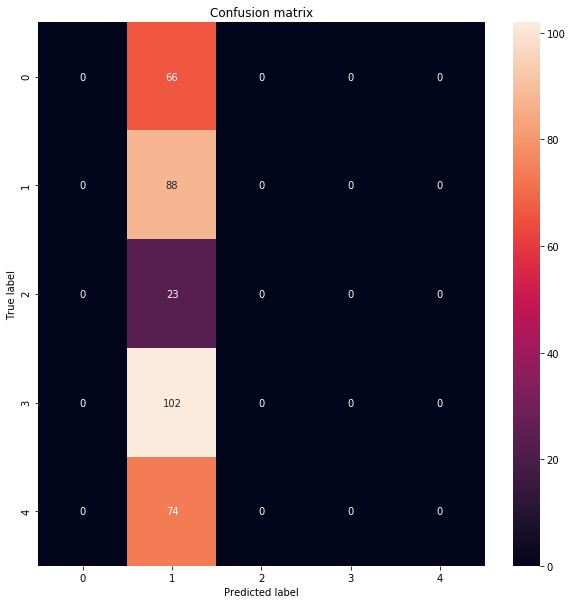

In [26]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, optimized)
plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show();

# Still one more question to ask
- To verify myself, I trained a neural network from Sklearn, which obtains a smaller loss (approx. 0.6) then the pytorch model (approx. 2.1), and the question is "What is different?"
- Both models use Adam as default with the default momentum hyperparameters, with constant learning rate and sam preprocessing methodology, relu activation and batch_size (at the moment of writing this I did not add LeakyReLU, BN or DropOut Regularization)
# And a possible answer:
- The MLPRegressor uses as loss function "squared_errors" with the regularization term that the MSELoss from Pytorch does not use, but I tried to simulate that regularization term by adding weight_decay to the Adam Optimizer... And it showed the same result.. so the question remains... What is different?

https://github.com/scikit-learn/scikit-learn/blob/95d4f0841/sklearn/neural_network/_multilayer_perceptron.py#L1083

Mean Squared Error Neural Network Sklearn:  0.8216090452173699


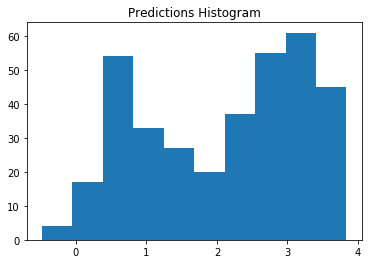

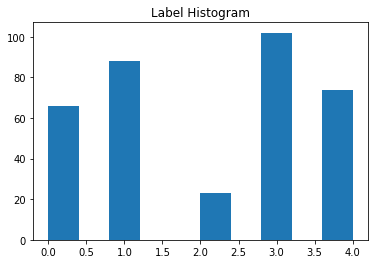

In [27]:
model = MLPRegressor(hidden_layer_sizes = (4), batch_size = 64, max_iter = 100)

model.fit(X_train_scaled, y_train)

y_predict = model.predict(X_test_scaled)

print("Mean Squared Error Neural Network Sklearn: ", mean_squared_error(y_predict, y_test))

plt.hist(y_predict)
plt.title("Predictions Histogram")
plt.show()

plt.hist(y_test)
plt.title("Label Histogram")
plt.show()

# And a simple Linear Regression

In [28]:
regressor = LinearRegression()
regressor.fit(X_train_scaled, y_train)
y_predict = regressor.predict(X_test_scaled)
print("Mean Squared Error Linear Regression Sklearn", mean_squared_error(y_predict, y_test))

Mean Squared Error Linear Regression Sklearn 1.1400216456050454


# And  now a more suitable regression problem for Price
- With Root Mean Square Log Error as loss function

In [29]:
data = pd.read_csv("Bucharest_HousePriceDataset.csv")

display(data.head(n = 10))

features = data.drop(['Pret'], axis = 1, inplace = False)

labels   = data["Pret"]

,Nr Camere,Suprafata,Etaj,Total Etaje,Sector,Scor,Pret
0,4,108.00,2,3,4,5,83000
1,1,41.00,1,8,1,1,39900
2,3,63.52,1,3,2,3,84900
3,1,33.00,3,10,5,1,45500
4,2,62.00,5,9,5,5,54900
5,3,132.00,2,6,1,2,349990
6,2,49.00,6,6,6,4,36500
7,3,92.00,4,8,2,2,119000
8,3,68.00,3,5,4,5,67500
9,3,110.00,1,2,1,1,133000


In [30]:
X_train, X_test, y_train, y_test = train_test_split(features.values, labels.values, train_size = 0.8, random_state = 42)

In [31]:
X_train_scaled, X_test_scaled, _ = preprocessing(X_train, X_test)

# Back to MSE
- I choose to use RMSLE Loss function to to get a better sense of the problem, but in some situations it was not well defined and it returned "nan" as loss value for training and validating steps, so I went back to MSE Loss function

Model for Fold: 0
Epoch: 1/1000..  Training Loss: 13374974112.914..  Test Loss: 12780661760.000.. 
Epoch: 2/1000..  Training Loss: 13581542955.886..  Test Loss: 13057370112.000.. 
Epoch: 3/1000..  Training Loss: 13451718992.457..  Test Loss: 12841475072.000.. 
Epoch: 4/1000..  Training Loss: 13462210560.000..  Test Loss: 12924775424.000.. 
Epoch: 5/1000..  Training Loss: 13500724838.400..  Test Loss: 12814572544.000.. 
Epoch: 6/1000..  Training Loss: 13461612017.371..  Test Loss: 12923874304.000.. 
Epoch: 7/1000..  Training Loss: 13510779084.800..  Test Loss: 12799073280.000.. 
Epoch: 8/1000..  Training Loss: 13559331401.143..  Test Loss: 12916927488.000.. 
Epoch: 9/1000..  Training Loss: 13407894089.143..  Test Loss: 12833338368.000.. 
Epoch: 10/1000..  Training Loss: 13447797877.029..  Test Loss: 12747672576.000.. 
Epoch: 11/1000..  Training Loss: 13518435006.171..  Test Loss: 12918100992.000.. 
Epoch: 12/1000..  Training Loss: 13418448954.514..  Test Loss: 12839652352.000.. 
Epoch: 

Epoch: 101/1000..  Training Loss: 12967962141.257..  Test Loss: 12512989184.000.. 
Epoch: 102/1000..  Training Loss: 12920208223.086..  Test Loss: 12294696960.000.. 
Epoch: 103/1000..  Training Loss: 13046954276.571..  Test Loss: 12308025344.000.. 
Epoch: 104/1000..  Training Loss: 13050155373.714..  Test Loss: 12499088384.000.. 
Epoch: 105/1000..  Training Loss: 12822409186.743..  Test Loss: 12407974912.000.. 
Epoch: 106/1000..  Training Loss: 12851602856.229..  Test Loss: 12372408320.000.. 
Epoch: 107/1000..  Training Loss: 12977759831.771..  Test Loss: 12232043520.000.. 
Epoch: 108/1000..  Training Loss: 12790891198.171..  Test Loss: 12529155072.000.. 
Epoch: 109/1000..  Training Loss: 12825526740.114..  Test Loss: 12403020800.000.. 
Epoch: 110/1000..  Training Loss: 13007699002.514..  Test Loss: 12425765888.000.. 
Epoch: 111/1000..  Training Loss: 12841263674.514..  Test Loss: 12381257728.000.. 
Epoch: 112/1000..  Training Loss: 12787153817.600..  Test Loss: 12330194944.000.. 
Epoc

Epoch: 201/1000..  Training Loss: 11868522261.943..  Test Loss: 11290524672.000.. 
Epoch: 202/1000..  Training Loss: 11743390164.114..  Test Loss: 11261991936.000.. 
Epoch: 203/1000..  Training Loss: 11681184533.943..  Test Loss: 11373341696.000.. 
Epoch: 204/1000..  Training Loss: 11659501860.571..  Test Loss: 11383070720.000.. 
Epoch: 205/1000..  Training Loss: 11666945726.171..  Test Loss: 11271813120.000.. 
Epoch: 206/1000..  Training Loss: 11757073115.429..  Test Loss: 11619338240.000.. 
Epoch: 207/1000..  Training Loss: 11661314925.714..  Test Loss: 11454401536.000.. 
Epoch: 208/1000..  Training Loss: 11765208766.171..  Test Loss: 11398079488.000.. 
Epoch: 209/1000..  Training Loss: 11717966204.343..  Test Loss: 11463416832.000.. 
Epoch: 210/1000..  Training Loss: 11653786229.029..  Test Loss: 11385732096.000.. 
Epoch: 211/1000..  Training Loss: 11531238253.714..  Test Loss: 11193512960.000.. 
Epoch: 212/1000..  Training Loss: 11598470758.400..  Test Loss: 11438492672.000.. 
Epoc

Epoch: 300/1000..  Training Loss: 10318955549.257..  Test Loss: 9945738240.000.. 
Epoch: 301/1000..  Training Loss: 10352509293.714..  Test Loss: 10094970880.000.. 
Epoch: 302/1000..  Training Loss: 10390355880.229..  Test Loss: 10042948608.000.. 
Epoch: 303/1000..  Training Loss: 10301036778.057..  Test Loss: 9987934208.000.. 
Epoch: 304/1000..  Training Loss: 10351410161.371..  Test Loss: 9896537088.000.. 
Epoch: 305/1000..  Training Loss: 10269415584.914..  Test Loss: 9905204224.000.. 
Epoch: 306/1000..  Training Loss: 10215107832.686..  Test Loss: 9909925888.000.. 
Epoch: 307/1000..  Training Loss: 10221952073.143..  Test Loss: 9950311424.000.. 
Epoch: 308/1000..  Training Loss: 10153957639.314..  Test Loss: 9982522368.000.. 
Epoch: 309/1000..  Training Loss: 10172984276.114..  Test Loss: 9893203968.000.. 
Epoch: 310/1000..  Training Loss: 10178550564.571..  Test Loss: 9771788288.000.. 
Epoch: 311/1000..  Training Loss: 10140044858.514..  Test Loss: 9877994496.000.. 
Epoch: 312/100

Epoch: 402/1000..  Training Loss: 8624675693.714..  Test Loss: 8261144064.000.. 
Epoch: 403/1000..  Training Loss: 8678835865.600..  Test Loss: 8349934592.000.. 
Epoch: 404/1000..  Training Loss: 8576995328.000..  Test Loss: 8557981696.000.. 
Epoch: 405/1000..  Training Loss: 8621975946.971..  Test Loss: 8380301312.000.. 
Epoch: 406/1000..  Training Loss: 8545155569.371..  Test Loss: 8359468544.000.. 
Epoch: 407/1000..  Training Loss: 8584222529.829..  Test Loss: 8486875136.000.. 
Epoch: 408/1000..  Training Loss: 8542607828.114..  Test Loss: 8298112000.000.. 
Epoch: 409/1000..  Training Loss: 8560624771.657..  Test Loss: 8324514816.000.. 
Epoch: 410/1000..  Training Loss: 8559731799.771..  Test Loss: 8221687808.000.. 
Epoch: 411/1000..  Training Loss: 8557534412.800..  Test Loss: 8309011456.000.. 
Epoch: 412/1000..  Training Loss: 8458546775.771..  Test Loss: 8298940928.000.. 
Epoch: 413/1000..  Training Loss: 8567920991.086..  Test Loss: 8081571328.000.. 
Epoch: 414/1000..  Training 

Epoch: 504/1000..  Training Loss: 7156512870.400..  Test Loss: 6825805312.000.. 
Epoch: 505/1000..  Training Loss: 7159343828.114..  Test Loss: 7011023360.000.. 
Epoch: 506/1000..  Training Loss: 7083628163.657..  Test Loss: 6800619008.000.. 
Epoch: 507/1000..  Training Loss: 6982054304.914..  Test Loss: 6759948288.000.. 
Epoch: 508/1000..  Training Loss: 7053921382.400..  Test Loss: 6800555520.000.. 
Epoch: 509/1000..  Training Loss: 7025863497.143..  Test Loss: 6909244416.000.. 
Epoch: 510/1000..  Training Loss: 7071926337.829..  Test Loss: 6684717568.000.. 
Epoch: 511/1000..  Training Loss: 7003987302.400..  Test Loss: 6722583552.000.. 
Epoch: 512/1000..  Training Loss: 6973994130.286..  Test Loss: 6851345408.000.. 
Epoch: 513/1000..  Training Loss: 7141972216.686..  Test Loss: 6574023680.000.. 
Epoch: 514/1000..  Training Loss: 7064879616.000..  Test Loss: 6777167872.000.. 
Epoch: 515/1000..  Training Loss: 7049120757.029..  Test Loss: 6738915840.000.. 
Epoch: 516/1000..  Training 

Epoch: 606/1000..  Training Loss: 5912513440.914..  Test Loss: 5459739136.000.. 
Epoch: 607/1000..  Training Loss: 5859402276.571..  Test Loss: 5475392512.000.. 
Epoch: 608/1000..  Training Loss: 5959117502.171..  Test Loss: 5400735232.000.. 
Epoch: 609/1000..  Training Loss: 5820144376.686..  Test Loss: 5508504064.000.. 
Epoch: 610/1000..  Training Loss: 5852240800.914..  Test Loss: 5460409856.000.. 
Epoch: 611/1000..  Training Loss: 5774400672.914..  Test Loss: 5347901952.000.. 
Epoch: 612/1000..  Training Loss: 5819193856.000..  Test Loss: 5539993088.000.. 
Epoch: 613/1000..  Training Loss: 5809126582.857..  Test Loss: 5619537408.000.. 
Epoch: 614/1000..  Training Loss: 5729027605.943..  Test Loss: 5666221056.000.. 
Epoch: 615/1000..  Training Loss: 5772936630.857..  Test Loss: 5530405376.000.. 
Epoch: 616/1000..  Training Loss: 5786854582.857..  Test Loss: 5352729088.000.. 
Epoch: 617/1000..  Training Loss: 5749472007.314..  Test Loss: 5317847040.000.. 
Epoch: 618/1000..  Training 

Epoch: 708/1000..  Training Loss: 4983742244.571..  Test Loss: 4392167936.000.. 
Epoch: 709/1000..  Training Loss: 5065506823.314..  Test Loss: 4478956544.000.. 
Epoch: 710/1000..  Training Loss: 5071791623.314..  Test Loss: 4444559360.000.. 
Epoch: 711/1000..  Training Loss: 5025816151.771..  Test Loss: 4341454848.000.. 
Epoch: 712/1000..  Training Loss: 5025572520.229..  Test Loss: 4402181632.000.. 
Epoch: 713/1000..  Training Loss: 5020895729.371..  Test Loss: 4336264192.000.. 
Epoch: 714/1000..  Training Loss: 5006501642.971..  Test Loss: 4367377408.000.. 
Epoch: 715/1000..  Training Loss: 5050372136.229..  Test Loss: 4380777984.000.. 
Epoch: 716/1000..  Training Loss: 4946935764.114..  Test Loss: 4375560704.000.. 
Epoch: 717/1000..  Training Loss: 4981889938.286..  Test Loss: 4285151232.000.. 
Epoch: 718/1000..  Training Loss: 4929836540.343..  Test Loss: 4338330112.000.. 
Epoch: 719/1000..  Training Loss: 5077103286.857..  Test Loss: 4318554112.000.. 
Epoch: 720/1000..  Training 

Epoch: 810/1000..  Training Loss: 4813899242.057..  Test Loss: 3964653312.000.. 
Epoch: 811/1000..  Training Loss: 4733367310.629..  Test Loss: 3904709120.000.. 
Epoch: 812/1000..  Training Loss: 4669906746.514..  Test Loss: 4024268800.000.. 
Epoch: 813/1000..  Training Loss: 4712437065.143..  Test Loss: 3908739840.000.. 
Epoch: 814/1000..  Training Loss: 4704078467.657..  Test Loss: 3845638656.000.. 
Epoch: 815/1000..  Training Loss: 4774092997.486..  Test Loss: 3911614464.000.. 
Epoch: 816/1000..  Training Loss: 4689220714.057..  Test Loss: 3840020224.000.. 
Epoch: 817/1000..  Training Loss: 4741322686.171..  Test Loss: 3837566976.000.. 
Epoch: 818/1000..  Training Loss: 4783762358.857..  Test Loss: 3898118912.000.. 
Epoch: 819/1000..  Training Loss: 4825590476.800..  Test Loss: 3855481344.000.. 
Epoch: 820/1000..  Training Loss: 4920179079.314..  Test Loss: 3916801280.000.. 
Epoch: 821/1000..  Training Loss: 4800452447.086..  Test Loss: 3902484480.000.. 
Epoch: 822/1000..  Training 

Epoch: 912/1000..  Training Loss: 4710324041.143..  Test Loss: 3756514048.000.. 
Epoch: 913/1000..  Training Loss: 4673558703.543..  Test Loss: 3778316288.000.. 
Epoch: 914/1000..  Training Loss: 4718587560.229..  Test Loss: 3868568064.000.. 
Epoch: 915/1000..  Training Loss: 4819143753.143..  Test Loss: 3775479808.000.. 
Epoch: 916/1000..  Training Loss: 4691478337.829..  Test Loss: 3871633408.000.. 
Epoch: 917/1000..  Training Loss: 4729405842.286..  Test Loss: 3713640192.000.. 
Epoch: 918/1000..  Training Loss: 4814014734.629..  Test Loss: 3748972544.000.. 
Epoch: 919/1000..  Training Loss: 4732845238.857..  Test Loss: 3815357184.000.. 
Epoch: 920/1000..  Training Loss: 4670567614.171..  Test Loss: 3852237568.000.. 
Epoch: 921/1000..  Training Loss: 4792584396.800..  Test Loss: 3811974912.000.. 
Epoch: 922/1000..  Training Loss: 4648534506.057..  Test Loss: 3805277952.000.. 
Epoch: 923/1000..  Training Loss: 4681934423.771..  Test Loss: 3787614208.000.. 
Epoch: 924/1000..  Training 

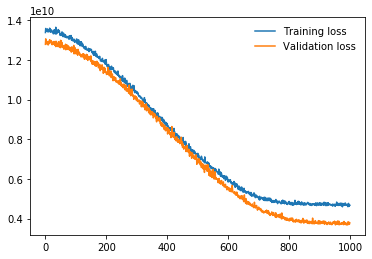

Model for Fold: 1
Epoch: 1/1000..  Training Loss: 13600880412.444..  Test Loss: 12165493760.000.. 
Epoch: 2/1000..  Training Loss: 13605958030.222..  Test Loss: 12080370688.000.. 
Epoch: 3/1000..  Training Loss: 13632243256.889..  Test Loss: 12133880832.000.. 
Epoch: 4/1000..  Training Loss: 13585665251.556..  Test Loss: 12143233024.000.. 
Epoch: 5/1000..  Training Loss: 13603674538.667..  Test Loss: 12064379904.000.. 
Epoch: 6/1000..  Training Loss: 13627998862.222..  Test Loss: 12220929024.000.. 
Epoch: 7/1000..  Training Loss: 13537611136.000..  Test Loss: 12042486784.000.. 
Epoch: 8/1000..  Training Loss: 13822302293.333..  Test Loss: 12149075968.000.. 
Epoch: 9/1000..  Training Loss: 13568410737.778..  Test Loss: 12197011456.000.. 
Epoch: 10/1000..  Training Loss: 13620502400.000..  Test Loss: 12218357760.000.. 
Epoch: 11/1000..  Training Loss: 13601096846.222..  Test Loss: 12326677504.000.. 
Epoch: 12/1000..  Training Loss: 13634538780.444..  Test Loss: 12196365312.000.. 
Epoch: 

Epoch: 101/1000..  Training Loss: 13023824839.111..  Test Loss: 11711730688.000.. 
Epoch: 102/1000..  Training Loss: 13110788408.889..  Test Loss: 11560692736.000.. 
Epoch: 103/1000..  Training Loss: 13062427306.667..  Test Loss: 11462097920.000.. 
Epoch: 104/1000..  Training Loss: 13076913351.111..  Test Loss: 11831738368.000.. 
Epoch: 105/1000..  Training Loss: 13040217685.333..  Test Loss: 11697682432.000.. 
Epoch: 106/1000..  Training Loss: 12977673329.778..  Test Loss: 11707332608.000.. 
Epoch: 107/1000..  Training Loss: 13113672618.667..  Test Loss: 11737842688.000.. 
Epoch: 108/1000..  Training Loss: 13097815651.556..  Test Loss: 11606021120.000.. 
Epoch: 109/1000..  Training Loss: 13008136590.222..  Test Loss: 11883378688.000.. 
Epoch: 110/1000..  Training Loss: 12990857713.778..  Test Loss: 11660499968.000.. 
Epoch: 111/1000..  Training Loss: 13002595143.111..  Test Loss: 11580322816.000.. 
Epoch: 112/1000..  Training Loss: 12950963114.667..  Test Loss: 11690224640.000.. 
Epoc

Epoch: 200/1000..  Training Loss: 12009304007.111..  Test Loss: 10601061376.000.. 
Epoch: 201/1000..  Training Loss: 11849976888.889..  Test Loss: 10725348352.000.. 
Epoch: 202/1000..  Training Loss: 12039452117.333..  Test Loss: 10553996288.000.. 
Epoch: 203/1000..  Training Loss: 11823470094.222..  Test Loss: 10601222144.000.. 
Epoch: 204/1000..  Training Loss: 11874536334.222..  Test Loss: 10428650496.000.. 
Epoch: 205/1000..  Training Loss: 11864881208.889..  Test Loss: 10511533056.000.. 
Epoch: 206/1000..  Training Loss: 11783902776.889..  Test Loss: 10728938496.000.. 
Epoch: 207/1000..  Training Loss: 11759823018.667..  Test Loss: 10487275520.000.. 
Epoch: 208/1000..  Training Loss: 11819719665.778..  Test Loss: 10402174976.000.. 
Epoch: 209/1000..  Training Loss: 11741138773.333..  Test Loss: 10264163328.000.. 
Epoch: 210/1000..  Training Loss: 11785053482.667..  Test Loss: 10378334208.000.. 
Epoch: 211/1000..  Training Loss: 11746766620.444..  Test Loss: 10427358208.000.. 
Epoc

Epoch: 300/1000..  Training Loss: 10381097685.333..  Test Loss: 9131769856.000.. 
Epoch: 301/1000..  Training Loss: 10374792561.778..  Test Loss: 9029889024.000.. 
Epoch: 302/1000..  Training Loss: 10377482382.222..  Test Loss: 9022635008.000.. 
Epoch: 303/1000..  Training Loss: 10249483861.333..  Test Loss: 9049913344.000.. 
Epoch: 304/1000..  Training Loss: 10387804515.556..  Test Loss: 9138359296.000.. 
Epoch: 305/1000..  Training Loss: 10252184988.444..  Test Loss: 8877074432.000.. 
Epoch: 306/1000..  Training Loss: 10331666645.333..  Test Loss: 9134741504.000.. 
Epoch: 307/1000..  Training Loss: 10244563697.778..  Test Loss: 8926314496.000.. 
Epoch: 308/1000..  Training Loss: 10256357361.778..  Test Loss: 9314504704.000.. 
Epoch: 309/1000..  Training Loss: 10303175751.111..  Test Loss: 8833281024.000.. 
Epoch: 310/1000..  Training Loss: 10293051790.222..  Test Loss: 8969296896.000.. 
Epoch: 311/1000..  Training Loss: 10193309724.444..  Test Loss: 8888432640.000.. 
Epoch: 312/1000.

Epoch: 401/1000..  Training Loss: 8752931911.111..  Test Loss: 7471928832.000.. 
Epoch: 402/1000..  Training Loss: 8730509112.889..  Test Loss: 7634611712.000.. 
Epoch: 403/1000..  Training Loss: 8584945550.222..  Test Loss: 7494944256.000.. 
Epoch: 404/1000..  Training Loss: 8627670812.444..  Test Loss: 7272616960.000.. 
Epoch: 405/1000..  Training Loss: 8611667854.222..  Test Loss: 7474271744.000.. 
Epoch: 406/1000..  Training Loss: 8630898218.667..  Test Loss: 7587138560.000.. 
Epoch: 407/1000..  Training Loss: 8695039559.111..  Test Loss: 7329415168.000.. 
Epoch: 408/1000..  Training Loss: 8589191552.000..  Test Loss: 7484285952.000.. 
Epoch: 409/1000..  Training Loss: 8705562837.333..  Test Loss: 7623101952.000.. 
Epoch: 410/1000..  Training Loss: 8502031822.222..  Test Loss: 7543689216.000.. 
Epoch: 411/1000..  Training Loss: 8549693553.778..  Test Loss: 7374986752.000.. 
Epoch: 412/1000..  Training Loss: 8531677930.667..  Test Loss: 7267517440.000.. 
Epoch: 413/1000..  Training 

Epoch: 503/1000..  Training Loss: 7093000718.222..  Test Loss: 6193806848.000.. 
Epoch: 504/1000..  Training Loss: 7054320120.889..  Test Loss: 6017048576.000.. 
Epoch: 505/1000..  Training Loss: 7076282232.889..  Test Loss: 5910601216.000.. 
Epoch: 506/1000..  Training Loss: 7083029646.222..  Test Loss: 5861331968.000.. 
Epoch: 507/1000..  Training Loss: 7162598954.667..  Test Loss: 5940743168.000.. 
Epoch: 508/1000..  Training Loss: 7034333063.111..  Test Loss: 5795236864.000.. 
Epoch: 509/1000..  Training Loss: 6984744192.000..  Test Loss: 6149834240.000.. 
Epoch: 510/1000..  Training Loss: 7020909048.889..  Test Loss: 5839221248.000.. 
Epoch: 511/1000..  Training Loss: 6971650304.000..  Test Loss: 5863308800.000.. 
Epoch: 512/1000..  Training Loss: 6883930837.333..  Test Loss: 5992151552.000.. 
Epoch: 513/1000..  Training Loss: 6987270741.333..  Test Loss: 5942361600.000.. 
Epoch: 514/1000..  Training Loss: 6926853098.667..  Test Loss: 5835471360.000.. 
Epoch: 515/1000..  Training 

Epoch: 605/1000..  Training Loss: 5799093390.222..  Test Loss: 4777553408.000.. 
Epoch: 606/1000..  Training Loss: 5762128760.889..  Test Loss: 4609311232.000.. 
Epoch: 607/1000..  Training Loss: 5796281432.889..  Test Loss: 4583754752.000.. 
Epoch: 608/1000..  Training Loss: 5723232497.778..  Test Loss: 4655171584.000.. 
Epoch: 609/1000..  Training Loss: 5723256711.111..  Test Loss: 4685200896.000.. 
Epoch: 610/1000..  Training Loss: 5820347512.889..  Test Loss: 4720925184.000.. 
Epoch: 611/1000..  Training Loss: 5711110549.333..  Test Loss: 4743760896.000.. 
Epoch: 612/1000..  Training Loss: 5721498197.333..  Test Loss: 4559378432.000.. 
Epoch: 613/1000..  Training Loss: 5662066496.000..  Test Loss: 4580357632.000.. 
Epoch: 614/1000..  Training Loss: 5722304853.333..  Test Loss: 4579153408.000.. 
Epoch: 615/1000..  Training Loss: 5740782741.333..  Test Loss: 4583505408.000.. 
Epoch: 616/1000..  Training Loss: 5726214016.000..  Test Loss: 4459987968.000.. 
Epoch: 617/1000..  Training 

Epoch: 707/1000..  Training Loss: 5008908689.778..  Test Loss: 3679616768.000.. 
Epoch: 708/1000..  Training Loss: 5052232234.667..  Test Loss: 3696185856.000.. 
Epoch: 709/1000..  Training Loss: 5002550449.778..  Test Loss: 3723211264.000.. 
Epoch: 710/1000..  Training Loss: 5098270364.444..  Test Loss: 3737652992.000.. 
Epoch: 711/1000..  Training Loss: 5061874616.889..  Test Loss: 3846009856.000.. 
Epoch: 712/1000..  Training Loss: 5117047928.889..  Test Loss: 3861284096.000.. 
Epoch: 713/1000..  Training Loss: 5032835434.667..  Test Loss: 3600974336.000.. 
Epoch: 714/1000..  Training Loss: 5048839736.889..  Test Loss: 3675136256.000.. 
Epoch: 715/1000..  Training Loss: 4964975832.889..  Test Loss: 3806789376.000.. 
Epoch: 716/1000..  Training Loss: 5043296437.333..  Test Loss: 3640641024.000.. 
Epoch: 717/1000..  Training Loss: 4986208419.556..  Test Loss: 3695558656.000.. 
Epoch: 718/1000..  Training Loss: 5045471296.000..  Test Loss: 3641033216.000.. 
Epoch: 719/1000..  Training 

Epoch: 809/1000..  Training Loss: 4761933319.111..  Test Loss: 3329954560.000.. 
Epoch: 810/1000..  Training Loss: 4757521649.778..  Test Loss: 3301285888.000.. 
Epoch: 811/1000..  Training Loss: 4812470826.667..  Test Loss: 3437466880.000.. 
Epoch: 812/1000..  Training Loss: 4797501304.889..  Test Loss: 3352818176.000.. 
Epoch: 813/1000..  Training Loss: 4841606869.333..  Test Loss: 3265905408.000.. 
Epoch: 814/1000..  Training Loss: 4889537500.444..  Test Loss: 3356723200.000.. 
Epoch: 815/1000..  Training Loss: 4748241489.778..  Test Loss: 3373190912.000.. 
Epoch: 816/1000..  Training Loss: 4803209112.889..  Test Loss: 3371912448.000.. 
Epoch: 817/1000..  Training Loss: 4838944213.333..  Test Loss: 3346400512.000.. 
Epoch: 818/1000..  Training Loss: 4875761820.444..  Test Loss: 3284825600.000.. 
Epoch: 819/1000..  Training Loss: 4806692007.111..  Test Loss: 3352162816.000.. 
Epoch: 820/1000..  Training Loss: 4794163783.111..  Test Loss: 3293349120.000.. 
Epoch: 821/1000..  Training 

Epoch: 911/1000..  Training Loss: 4682991395.556..  Test Loss: 3269492224.000.. 
Epoch: 912/1000..  Training Loss: 4853291370.667..  Test Loss: 3292158976.000.. 
Epoch: 913/1000..  Training Loss: 4729490986.667..  Test Loss: 3172694016.000.. 
Epoch: 914/1000..  Training Loss: 4722390481.778..  Test Loss: 3189059584.000.. 
Epoch: 915/1000..  Training Loss: 4737333880.889..  Test Loss: 3270188544.000.. 
Epoch: 916/1000..  Training Loss: 4702634723.556..  Test Loss: 3237345024.000.. 
Epoch: 917/1000..  Training Loss: 4744189347.556..  Test Loss: 3312386304.000.. 
Epoch: 918/1000..  Training Loss: 4743399573.333..  Test Loss: 3234922752.000.. 
Epoch: 919/1000..  Training Loss: 4743109155.556..  Test Loss: 3222578432.000.. 
Epoch: 920/1000..  Training Loss: 4767893724.444..  Test Loss: 3216533760.000.. 
Epoch: 921/1000..  Training Loss: 4762551278.222..  Test Loss: 3285374720.000.. 
Epoch: 922/1000..  Training Loss: 4770999829.333..  Test Loss: 3228764928.000.. 
Epoch: 923/1000..  Training 

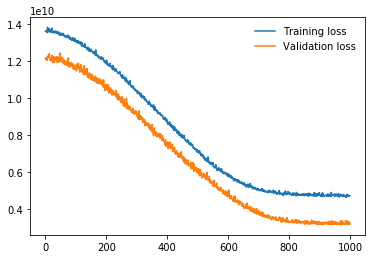

Model for Fold: 2
Epoch: 1/1000..  Training Loss: 12669026889.143..  Test Loss: 15737418752.000.. 
Epoch: 2/1000..  Training Loss: 12656311764.114..  Test Loss: 16009387008.000.. 
Epoch: 3/1000..  Training Loss: 12652435017.143..  Test Loss: 15796071424.000.. 
Epoch: 4/1000..  Training Loss: 12663856640.000..  Test Loss: 15266553856.000.. 
Epoch: 5/1000..  Training Loss: 12660785034.971..  Test Loss: 15910632448.000.. 
Epoch: 6/1000..  Training Loss: 12657456230.400..  Test Loss: 16376496128.000.. 
Epoch: 7/1000..  Training Loss: 12662578673.371..  Test Loss: 15444235264.000.. 
Epoch: 8/1000..  Training Loss: 12662917939.200..  Test Loss: 15742260224.000.. 
Epoch: 9/1000..  Training Loss: 12652243733.943..  Test Loss: 16394520576.000.. 
Epoch: 10/1000..  Training Loss: 12657618329.600..  Test Loss: 16373794816.000.. 
Epoch: 11/1000..  Training Loss: 12639624864.914..  Test Loss: 18157115392.000.. 
Epoch: 12/1000..  Training Loss: 12657481962.057..  Test Loss: 15692963840.000.. 
Epoch: 

Epoch: 102/1000..  Training Loss: 12138294389.029..  Test Loss: 15642055680.000.. 
Epoch: 103/1000..  Training Loss: 12129518796.800..  Test Loss: 14786933760.000.. 
Epoch: 104/1000..  Training Loss: 12118047978.057..  Test Loss: 15958801408.000.. 
Epoch: 105/1000..  Training Loss: 12098757163.886..  Test Loss: 15010547712.000.. 
Epoch: 106/1000..  Training Loss: 12109785980.343..  Test Loss: 14807302144.000.. 
Epoch: 107/1000..  Training Loss: 12097912334.629..  Test Loss: 15434263552.000.. 
Epoch: 108/1000..  Training Loss: 12077606122.057..  Test Loss: 14509665280.000.. 
Epoch: 109/1000..  Training Loss: 12069134833.371..  Test Loss: 15200474112.000.. 
Epoch: 110/1000..  Training Loss: 12067877800.229..  Test Loss: 14896106496.000.. 
Epoch: 111/1000..  Training Loss: 12052425157.486..  Test Loss: 14925490176.000.. 
Epoch: 112/1000..  Training Loss: 12041872647.314..  Test Loss: 14898341888.000.. 
Epoch: 113/1000..  Training Loss: 12015228986.514..  Test Loss: 14929574912.000.. 
Epoc

Epoch: 202/1000..  Training Loss: 11046546358.857..  Test Loss: 13757769728.000.. 
Epoch: 203/1000..  Training Loss: 11014784394.971..  Test Loss: 13756173312.000.. 
Epoch: 204/1000..  Training Loss: 11011577797.486..  Test Loss: 14338408448.000.. 
Epoch: 205/1000..  Training Loss: 10980645054.171..  Test Loss: 14114700288.000.. 
Epoch: 206/1000..  Training Loss: 10967151221.029..  Test Loss: 14303009792.000.. 
Epoch: 207/1000..  Training Loss: 10934554053.486..  Test Loss: 15092599808.000.. 
Epoch: 208/1000..  Training Loss: 10957992799.086..  Test Loss: 14266561536.000.. 
Epoch: 209/1000..  Training Loss: 10921156768.914..  Test Loss: 14496882688.000.. 
Epoch: 210/1000..  Training Loss: 10897231886.629..  Test Loss: 14020558848.000.. 
Epoch: 211/1000..  Training Loss: 10912909897.143..  Test Loss: 14707211264.000.. 
Epoch: 212/1000..  Training Loss: 10883370057.143..  Test Loss: 14340013056.000.. 
Epoch: 213/1000..  Training Loss: 10880849451.886..  Test Loss: 14835337216.000.. 
Epoc

Epoch: 302/1000..  Training Loss: 9597654206.171..  Test Loss: 12800060416.000.. 
Epoch: 303/1000..  Training Loss: 9590282137.600..  Test Loss: 12119351296.000.. 
Epoch: 304/1000..  Training Loss: 9593086420.114..  Test Loss: 12162673664.000.. 
Epoch: 305/1000..  Training Loss: 9532464069.486..  Test Loss: 12436225024.000.. 
Epoch: 306/1000..  Training Loss: 9510805006.629..  Test Loss: 12502927360.000.. 
Epoch: 307/1000..  Training Loss: 9482427772.343..  Test Loss: 12238064640.000.. 
Epoch: 308/1000..  Training Loss: 9521716560.457..  Test Loss: 12631284736.000.. 
Epoch: 309/1000..  Training Loss: 9490815963.429..  Test Loss: 12377606144.000.. 
Epoch: 310/1000..  Training Loss: 9472328777.143..  Test Loss: 12561781760.000.. 
Epoch: 311/1000..  Training Loss: 9425634157.714..  Test Loss: 12050363392.000.. 
Epoch: 312/1000..  Training Loss: 9477270103.771..  Test Loss: 11918107648.000.. 
Epoch: 313/1000..  Training Loss: 9397048905.143..  Test Loss: 12687497216.000.. 
Epoch: 314/1000.

Epoch: 402/1000..  Training Loss: 8041882989.714..  Test Loss: 11000938496.000.. 
Epoch: 403/1000..  Training Loss: 8025878235.429..  Test Loss: 10628896768.000.. 
Epoch: 404/1000..  Training Loss: 8002421379.657..  Test Loss: 10992062464.000.. 
Epoch: 405/1000..  Training Loss: 7980728583.314..  Test Loss: 10935503872.000.. 
Epoch: 406/1000..  Training Loss: 8002743244.800..  Test Loss: 10409346048.000.. 
Epoch: 407/1000..  Training Loss: 7979947710.171..  Test Loss: 10396314624.000.. 
Epoch: 408/1000..  Training Loss: 7995043781.486..  Test Loss: 10639760384.000.. 
Epoch: 409/1000..  Training Loss: 7938088872.229..  Test Loss: 10775516160.000.. 
Epoch: 410/1000..  Training Loss: 7936780375.771..  Test Loss: 11048728576.000.. 
Epoch: 411/1000..  Training Loss: 7893963666.286..  Test Loss: 11471983616.000.. 
Epoch: 412/1000..  Training Loss: 7876150272.000..  Test Loss: 10793402368.000.. 
Epoch: 413/1000..  Training Loss: 7914033898.057..  Test Loss: 11193231360.000.. 
Epoch: 414/1000.

Epoch: 503/1000..  Training Loss: 6429039455.086..  Test Loss: 9418103808.000.. 
Epoch: 504/1000..  Training Loss: 6517950061.714..  Test Loss: 9158310912.000.. 
Epoch: 505/1000..  Training Loss: 6441916562.286..  Test Loss: 10595212288.000.. 
Epoch: 506/1000..  Training Loss: 6455664676.571..  Test Loss: 9048393728.000.. 
Epoch: 507/1000..  Training Loss: 6475858885.486..  Test Loss: 8947080192.000.. 
Epoch: 508/1000..  Training Loss: 6417376256.000..  Test Loss: 8894618624.000.. 
Epoch: 509/1000..  Training Loss: 6391852653.714..  Test Loss: 9565035520.000.. 
Epoch: 510/1000..  Training Loss: 6444616469.943..  Test Loss: 8794999808.000.. 
Epoch: 511/1000..  Training Loss: 6390027081.143..  Test Loss: 8938780672.000.. 
Epoch: 512/1000..  Training Loss: 6367032429.714..  Test Loss: 8681574400.000.. 
Epoch: 513/1000..  Training Loss: 6361038679.771..  Test Loss: 8856160256.000.. 
Epoch: 514/1000..  Training Loss: 6321306499.657..  Test Loss: 8864295936.000.. 
Epoch: 515/1000..  Training

Epoch: 605/1000..  Training Loss: 5259858907.429..  Test Loss: 7871129088.000.. 
Epoch: 606/1000..  Training Loss: 5213382414.629..  Test Loss: 7296440832.000.. 
Epoch: 607/1000..  Training Loss: 5249274744.686..  Test Loss: 7480967168.000.. 
Epoch: 608/1000..  Training Loss: 5150644794.514..  Test Loss: 7847667200.000.. 
Epoch: 609/1000..  Training Loss: 5251508114.286..  Test Loss: 7315163648.000.. 
Epoch: 610/1000..  Training Loss: 5231954161.371..  Test Loss: 7453594624.000.. 
Epoch: 611/1000..  Training Loss: 5196398877.257..  Test Loss: 8217703424.000.. 
Epoch: 612/1000..  Training Loss: 5238325101.714..  Test Loss: 7396624896.000.. 
Epoch: 613/1000..  Training Loss: 5122337448.229..  Test Loss: 7003514368.000.. 
Epoch: 614/1000..  Training Loss: 5173334842.514..  Test Loss: 8601771008.000.. 
Epoch: 615/1000..  Training Loss: 5159837432.686..  Test Loss: 7072259584.000.. 
Epoch: 616/1000..  Training Loss: 5117183729.371..  Test Loss: 8105735680.000.. 
Epoch: 617/1000..  Training 

Epoch: 707/1000..  Training Loss: 4582533544.229..  Test Loss: 5973289984.000.. 
Epoch: 708/1000..  Training Loss: 4485167488.000..  Test Loss: 6740759552.000.. 
Epoch: 709/1000..  Training Loss: 4552051090.286..  Test Loss: 6027549184.000.. 
Epoch: 710/1000..  Training Loss: 4510674110.171..  Test Loss: 6273014272.000.. 
Epoch: 711/1000..  Training Loss: 4488514208.914..  Test Loss: 5928653312.000.. 
Epoch: 712/1000..  Training Loss: 4542912329.143..  Test Loss: 5911382016.000.. 
Epoch: 713/1000..  Training Loss: 4519859931.429..  Test Loss: 5936897024.000.. 
Epoch: 714/1000..  Training Loss: 4462409172.114..  Test Loss: 6020154880.000.. 
Epoch: 715/1000..  Training Loss: 4550862310.400..  Test Loss: 5985801216.000.. 
Epoch: 716/1000..  Training Loss: 4510479074.743..  Test Loss: 6982106624.000.. 
Epoch: 717/1000..  Training Loss: 4473304261.486..  Test Loss: 6520206336.000.. 
Epoch: 718/1000..  Training Loss: 4503150752.914..  Test Loss: 5935517184.000.. 
Epoch: 719/1000..  Training 

Epoch: 809/1000..  Training Loss: 4338781096.229..  Test Loss: 5596061696.000.. 
Epoch: 810/1000..  Training Loss: 4313038500.571..  Test Loss: 5613283328.000.. 
Epoch: 811/1000..  Training Loss: 4365875006.171..  Test Loss: 5367595520.000.. 
Epoch: 812/1000..  Training Loss: 4280495725.714..  Test Loss: 5498762752.000.. 
Epoch: 813/1000..  Training Loss: 4274877805.714..  Test Loss: 5786848768.000.. 
Epoch: 814/1000..  Training Loss: 4297410311.314..  Test Loss: 5367453696.000.. 
Epoch: 815/1000..  Training Loss: 4358283307.886..  Test Loss: 6074136064.000.. 
Epoch: 816/1000..  Training Loss: 4280719758.629..  Test Loss: 5687689216.000.. 
Epoch: 817/1000..  Training Loss: 4288400512.000..  Test Loss: 6109568512.000.. 
Epoch: 818/1000..  Training Loss: 4335200643.657..  Test Loss: 5707776512.000.. 
Epoch: 819/1000..  Training Loss: 4293550343.314..  Test Loss: 6013563392.000.. 
Epoch: 820/1000..  Training Loss: 4353635733.943..  Test Loss: 5296778752.000.. 
Epoch: 821/1000..  Training 

Epoch: 911/1000..  Training Loss: 4240629705.143..  Test Loss: 5200855040.000.. 
Epoch: 912/1000..  Training Loss: 4287711941.486..  Test Loss: 6336897536.000.. 
Epoch: 913/1000..  Training Loss: 4276978768.457..  Test Loss: 5471086080.000.. 
Epoch: 914/1000..  Training Loss: 4261664512.000..  Test Loss: 5203554304.000.. 
Epoch: 915/1000..  Training Loss: 4285126736.457..  Test Loss: 5288817152.000.. 
Epoch: 916/1000..  Training Loss: 4233980558.629..  Test Loss: 5152904704.000.. 
Epoch: 917/1000..  Training Loss: 4246422008.686..  Test Loss: 5309124608.000.. 
Epoch: 918/1000..  Training Loss: 4315710003.200..  Test Loss: 5418955776.000.. 
Epoch: 919/1000..  Training Loss: 4278514797.714..  Test Loss: 6252338688.000.. 
Epoch: 920/1000..  Training Loss: 4314565602.743..  Test Loss: 5270299648.000.. 
Epoch: 921/1000..  Training Loss: 4259667434.057..  Test Loss: 5247622656.000.. 
Epoch: 922/1000..  Training Loss: 4249065055.086..  Test Loss: 5503545344.000.. 
Epoch: 923/1000..  Training 

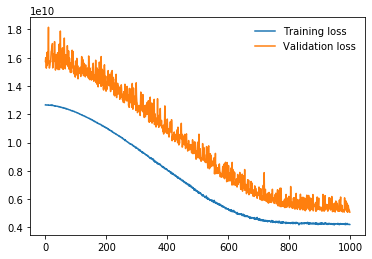

Model for Fold: 3
Epoch: 1/1000..  Training Loss: 13536281486.222..  Test Loss: 12812148736.000.. 
Epoch: 2/1000..  Training Loss: 13525072170.667..  Test Loss: 12515994624.000.. 
Epoch: 3/1000..  Training Loss: 13491487459.556..  Test Loss: 12672442368.000.. 
Epoch: 4/1000..  Training Loss: 13472110520.889..  Test Loss: 12559864832.000.. 
Epoch: 5/1000..  Training Loss: 13448138595.556..  Test Loss: 12700618752.000.. 
Epoch: 6/1000..  Training Loss: 13523776028.444..  Test Loss: 12631339008.000.. 
Epoch: 7/1000..  Training Loss: 13518634666.667..  Test Loss: 12642081792.000.. 
Epoch: 8/1000..  Training Loss: 13529272604.444..  Test Loss: 12994646016.000.. 
Epoch: 9/1000..  Training Loss: 13517327701.333..  Test Loss: 12683692032.000.. 
Epoch: 10/1000..  Training Loss: 13587248625.778..  Test Loss: 12677635072.000.. 
Epoch: 11/1000..  Training Loss: 13507817713.778..  Test Loss: 12836400128.000.. 
Epoch: 12/1000..  Training Loss: 13473678904.889..  Test Loss: 12749394944.000.. 
Epoch: 

Epoch: 102/1000..  Training Loss: 13008177052.444..  Test Loss: 12295663616.000.. 
Epoch: 103/1000..  Training Loss: 12898697415.111..  Test Loss: 12129484800.000.. 
Epoch: 104/1000..  Training Loss: 12952499640.889..  Test Loss: 12150447104.000.. 
Epoch: 105/1000..  Training Loss: 12894134855.111..  Test Loss: 11985804288.000.. 
Epoch: 106/1000..  Training Loss: 12906342855.111..  Test Loss: 12110648320.000.. 
Epoch: 107/1000..  Training Loss: 12916679964.444..  Test Loss: 12128334848.000.. 
Epoch: 108/1000..  Training Loss: 12902495786.667..  Test Loss: 12170287104.000.. 
Epoch: 109/1000..  Training Loss: 12908786844.444..  Test Loss: 12132979712.000.. 
Epoch: 110/1000..  Training Loss: 12864619477.333..  Test Loss: 12056118272.000.. 
Epoch: 111/1000..  Training Loss: 12875359772.444..  Test Loss: 11933497344.000.. 
Epoch: 112/1000..  Training Loss: 12842326528.000..  Test Loss: 12137662464.000.. 
Epoch: 113/1000..  Training Loss: 12854300757.333..  Test Loss: 12221969408.000.. 
Epoc

Epoch: 202/1000..  Training Loss: 11771556224.000..  Test Loss: 11021860864.000.. 
Epoch: 203/1000..  Training Loss: 11744330666.667..  Test Loss: 11016042496.000.. 
Epoch: 204/1000..  Training Loss: 11709540352.000..  Test Loss: 10875217920.000.. 
Epoch: 205/1000..  Training Loss: 11710211484.444..  Test Loss: 11164878848.000.. 
Epoch: 206/1000..  Training Loss: 11707068472.889..  Test Loss: 10868649984.000.. 
Epoch: 207/1000..  Training Loss: 11715562766.222..  Test Loss: 10894639104.000.. 
Epoch: 208/1000..  Training Loss: 11674420593.778..  Test Loss: 10774798336.000.. 
Epoch: 209/1000..  Training Loss: 11626897493.333..  Test Loss: 10863174656.000.. 
Epoch: 210/1000..  Training Loss: 11697884771.556..  Test Loss: 10848261120.000.. 
Epoch: 211/1000..  Training Loss: 11599469269.333..  Test Loss: 11287930880.000.. 
Epoch: 212/1000..  Training Loss: 11645240462.222..  Test Loss: 11039905792.000.. 
Epoch: 213/1000..  Training Loss: 11606158065.778..  Test Loss: 11015096320.000.. 
Epoc

Epoch: 302/1000..  Training Loss: 10190201528.889..  Test Loss: 9498443776.000.. 
Epoch: 303/1000..  Training Loss: 10195762488.889..  Test Loss: 9812255744.000.. 
Epoch: 304/1000..  Training Loss: 10169870165.333..  Test Loss: 9159165952.000.. 
Epoch: 305/1000..  Training Loss: 10128059335.111..  Test Loss: 9931873280.000.. 
Epoch: 306/1000..  Training Loss: 10095677895.111..  Test Loss: 9287589888.000.. 
Epoch: 307/1000..  Training Loss: 10109972792.889..  Test Loss: 9758571520.000.. 
Epoch: 308/1000..  Training Loss: 10120830691.556..  Test Loss: 9840208896.000.. 
Epoch: 309/1000..  Training Loss: 10092755271.111..  Test Loss: 9732025344.000.. 
Epoch: 310/1000..  Training Loss: 10108491520.000..  Test Loss: 9376404480.000.. 
Epoch: 311/1000..  Training Loss: 10078587633.778..  Test Loss: 9648377856.000.. 
Epoch: 312/1000..  Training Loss: 10014482872.889..  Test Loss: 9394804736.000.. 
Epoch: 313/1000..  Training Loss: 10044330453.333..  Test Loss: 9299280896.000.. 
Epoch: 314/1000.

Epoch: 404/1000..  Training Loss: 8501007217.778..  Test Loss: 8150478336.000.. 
Epoch: 405/1000..  Training Loss: 8527216327.111..  Test Loss: 8125884928.000.. 
Epoch: 406/1000..  Training Loss: 8458553301.333..  Test Loss: 8263526400.000.. 
Epoch: 407/1000..  Training Loss: 8399985088.000..  Test Loss: 7720908288.000.. 
Epoch: 408/1000..  Training Loss: 8408374115.556..  Test Loss: 7912299520.000.. 
Epoch: 409/1000..  Training Loss: 8424944426.667..  Test Loss: 7829346816.000.. 
Epoch: 410/1000..  Training Loss: 8402031701.333..  Test Loss: 7973418496.000.. 
Epoch: 411/1000..  Training Loss: 8381066695.111..  Test Loss: 7679772672.000.. 
Epoch: 412/1000..  Training Loss: 8359747712.000..  Test Loss: 7728572928.000.. 
Epoch: 413/1000..  Training Loss: 8298044657.778..  Test Loss: 8071801344.000.. 
Epoch: 414/1000..  Training Loss: 8337753194.667..  Test Loss: 8151972352.000.. 
Epoch: 415/1000..  Training Loss: 8224480085.333..  Test Loss: 7724077568.000.. 
Epoch: 416/1000..  Training 

Epoch: 506/1000..  Training Loss: 6895689024.000..  Test Loss: 6737260544.000.. 
Epoch: 507/1000..  Training Loss: 6815867050.667..  Test Loss: 6457538048.000.. 
Epoch: 508/1000..  Training Loss: 6823071011.556..  Test Loss: 6159113216.000.. 
Epoch: 509/1000..  Training Loss: 6765406407.111..  Test Loss: 6407475712.000.. 
Epoch: 510/1000..  Training Loss: 6786608426.667..  Test Loss: 6353097216.000.. 
Epoch: 511/1000..  Training Loss: 6797058474.667..  Test Loss: 6568049664.000.. 
Epoch: 512/1000..  Training Loss: 6750999644.444..  Test Loss: 6185045504.000.. 
Epoch: 513/1000..  Training Loss: 6781419349.333..  Test Loss: 6093906432.000.. 
Epoch: 514/1000..  Training Loss: 6814831914.667..  Test Loss: 6386309120.000.. 
Epoch: 515/1000..  Training Loss: 6712443612.444..  Test Loss: 6197099008.000.. 
Epoch: 516/1000..  Training Loss: 6755359274.667..  Test Loss: 6280966656.000.. 
Epoch: 517/1000..  Training Loss: 6731366236.444..  Test Loss: 5984226304.000.. 
Epoch: 518/1000..  Training 

Epoch: 608/1000..  Training Loss: 5575881592.889..  Test Loss: 4650885632.000.. 
Epoch: 609/1000..  Training Loss: 5584128412.444..  Test Loss: 5157371392.000.. 
Epoch: 610/1000..  Training Loss: 5638693852.444..  Test Loss: 4907681280.000.. 
Epoch: 611/1000..  Training Loss: 5517798855.111..  Test Loss: 4708140032.000.. 
Epoch: 612/1000..  Training Loss: 5592462208.000..  Test Loss: 4755401216.000.. 
Epoch: 613/1000..  Training Loss: 5511762076.444..  Test Loss: 4694604800.000.. 
Epoch: 614/1000..  Training Loss: 5519040355.556..  Test Loss: 5084887552.000.. 
Epoch: 615/1000..  Training Loss: 5597265806.222..  Test Loss: 5278124544.000.. 
Epoch: 616/1000..  Training Loss: 5512586410.667..  Test Loss: 4663622144.000.. 
Epoch: 617/1000..  Training Loss: 5519449692.444..  Test Loss: 4776563712.000.. 
Epoch: 618/1000..  Training Loss: 5477509468.444..  Test Loss: 5191395328.000.. 
Epoch: 619/1000..  Training Loss: 5449455580.444..  Test Loss: 4873057792.000.. 
Epoch: 620/1000..  Training 

Epoch: 710/1000..  Training Loss: 4861754026.667..  Test Loss: 4073857536.000.. 
Epoch: 711/1000..  Training Loss: 4939917440.000..  Test Loss: 4057767168.000.. 
Epoch: 712/1000..  Training Loss: 5006923242.667..  Test Loss: 4170094848.000.. 
Epoch: 713/1000..  Training Loss: 4890100352.000..  Test Loss: 4190633472.000.. 
Epoch: 714/1000..  Training Loss: 4915649443.556..  Test Loss: 4184980992.000.. 
Epoch: 715/1000..  Training Loss: 4923380750.222..  Test Loss: 4222227712.000.. 
Epoch: 716/1000..  Training Loss: 4933375495.111..  Test Loss: 3997136640.000.. 
Epoch: 717/1000..  Training Loss: 4932415452.444..  Test Loss: 4004873216.000.. 
Epoch: 718/1000..  Training Loss: 4914725098.667..  Test Loss: 3895785216.000.. 
Epoch: 719/1000..  Training Loss: 4965385976.889..  Test Loss: 3716915968.000.. 
Epoch: 720/1000..  Training Loss: 4867100024.889..  Test Loss: 4174452992.000.. 
Epoch: 721/1000..  Training Loss: 4946134641.778..  Test Loss: 4111801088.000.. 
Epoch: 722/1000..  Training 

Epoch: 812/1000..  Training Loss: 4735162673.778..  Test Loss: 3468200448.000.. 
Epoch: 813/1000..  Training Loss: 4730663921.778..  Test Loss: 3575203328.000.. 
Epoch: 814/1000..  Training Loss: 4758595072.000..  Test Loss: 3705097984.000.. 
Epoch: 815/1000..  Training Loss: 4759765447.111..  Test Loss: 3484908800.000.. 
Epoch: 816/1000..  Training Loss: 4719009080.889..  Test Loss: 3496084736.000.. 
Epoch: 817/1000..  Training Loss: 4748142080.000..  Test Loss: 3582889216.000.. 
Epoch: 818/1000..  Training Loss: 4783912071.111..  Test Loss: 3724666112.000.. 
Epoch: 819/1000..  Training Loss: 4714235086.222..  Test Loss: 3930396928.000.. 
Epoch: 820/1000..  Training Loss: 4745577920.000..  Test Loss: 3574641920.000.. 
Epoch: 821/1000..  Training Loss: 4786297678.222..  Test Loss: 3424856832.000.. 
Epoch: 822/1000..  Training Loss: 4776323072.000..  Test Loss: 3975125760.000.. 
Epoch: 823/1000..  Training Loss: 4743271872.000..  Test Loss: 3596131840.000.. 
Epoch: 824/1000..  Training 

Epoch: 914/1000..  Training Loss: 4774623096.889..  Test Loss: 3560711168.000.. 
Epoch: 915/1000..  Training Loss: 4720835840.000..  Test Loss: 3474413568.000.. 
Epoch: 916/1000..  Training Loss: 4753025600.000..  Test Loss: 3563407104.000.. 
Epoch: 917/1000..  Training Loss: 4681187413.333..  Test Loss: 3651666176.000.. 
Epoch: 918/1000..  Training Loss: 4673553841.778..  Test Loss: 3491347456.000.. 
Epoch: 919/1000..  Training Loss: 4736479637.333..  Test Loss: 3477864192.000.. 
Epoch: 920/1000..  Training Loss: 4676701624.889..  Test Loss: 3705793536.000.. 
Epoch: 921/1000..  Training Loss: 4735533717.333..  Test Loss: 3499648256.000.. 
Epoch: 922/1000..  Training Loss: 4817816348.444..  Test Loss: 3800012032.000.. 
Epoch: 923/1000..  Training Loss: 4750814940.444..  Test Loss: 3419432192.000.. 
Epoch: 924/1000..  Training Loss: 4746243456.000..  Test Loss: 3397370880.000.. 
Epoch: 925/1000..  Training Loss: 4712583324.444..  Test Loss: 3413023232.000.. 
Epoch: 926/1000..  Training 

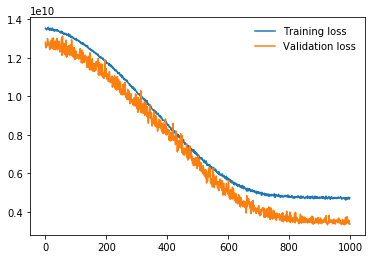

Model for Fold: 4
Epoch: 1/1000..  Training Loss: 13471076750.222..  Test Loss: 13435499520.000.. 
Epoch: 2/1000..  Training Loss: 13476426808.889..  Test Loss: 12462203904.000.. 
Epoch: 3/1000..  Training Loss: 13467530695.111..  Test Loss: 12237198336.000.. 
Epoch: 4/1000..  Training Loss: 13466457031.111..  Test Loss: 12356546560.000.. 
Epoch: 5/1000..  Training Loss: 13463654940.444..  Test Loss: 12188789760.000.. 
Epoch: 6/1000..  Training Loss: 13463910286.222..  Test Loss: 12905364480.000.. 
Epoch: 7/1000..  Training Loss: 13466768270.222..  Test Loss: 13349967872.000.. 
Epoch: 8/1000..  Training Loss: 13464846449.778..  Test Loss: 12611162112.000.. 
Epoch: 9/1000..  Training Loss: 13463840654.222..  Test Loss: 12277977088.000.. 
Epoch: 10/1000..  Training Loss: 13461132472.889..  Test Loss: 14652962816.000.. 
Epoch: 11/1000..  Training Loss: 13462310428.444..  Test Loss: 12608861184.000.. 
Epoch: 12/1000..  Training Loss: 13460345543.111..  Test Loss: 12344215552.000.. 
Epoch: 

Epoch: 101/1000..  Training Loss: 12913528348.444..  Test Loss: 12054746112.000.. 
Epoch: 102/1000..  Training Loss: 12904037432.889..  Test Loss: 11907888128.000.. 
Epoch: 103/1000..  Training Loss: 12898434232.889..  Test Loss: 12705444864.000.. 
Epoch: 104/1000..  Training Loss: 12890815488.000..  Test Loss: 12196974592.000.. 
Epoch: 105/1000..  Training Loss: 12876643783.111..  Test Loss: 12351934464.000.. 
Epoch: 106/1000..  Training Loss: 12867912135.111..  Test Loss: 13803936768.000.. 
Epoch: 107/1000..  Training Loss: 12858821831.111..  Test Loss: 14318442496.000.. 
Epoch: 108/1000..  Training Loss: 12850708736.000..  Test Loss: 12746627072.000.. 
Epoch: 109/1000..  Training Loss: 12840960896.000..  Test Loss: 12054762496.000.. 
Epoch: 110/1000..  Training Loss: 12840085560.889..  Test Loss: 11894002688.000.. 
Epoch: 111/1000..  Training Loss: 12814545991.111..  Test Loss: 13583438848.000.. 
Epoch: 112/1000..  Training Loss: 12806446677.333..  Test Loss: 11983449088.000.. 
Epoc

Epoch: 200/1000..  Training Loss: 11749514538.667..  Test Loss: 12110118912.000.. 
Epoch: 201/1000..  Training Loss: 11755615189.333..  Test Loss: 11948893184.000.. 
Epoch: 202/1000..  Training Loss: 11709516074.667..  Test Loss: 11460212736.000.. 
Epoch: 203/1000..  Training Loss: 11717237632.000..  Test Loss: 13099853824.000.. 
Epoch: 204/1000..  Training Loss: 11715677084.444..  Test Loss: 11446629376.000.. 
Epoch: 205/1000..  Training Loss: 11689839047.111..  Test Loss: 12340354048.000.. 
Epoch: 206/1000..  Training Loss: 11659448391.111..  Test Loss: 11828199424.000.. 
Epoch: 207/1000..  Training Loss: 11647068529.778..  Test Loss: 11739993088.000.. 
Epoch: 208/1000..  Training Loss: 11640826979.556..  Test Loss: 11679000576.000.. 
Epoch: 209/1000..  Training Loss: 11620109454.222..  Test Loss: 11523571712.000.. 
Epoch: 210/1000..  Training Loss: 11608312533.333..  Test Loss: 12477698048.000.. 
Epoch: 211/1000..  Training Loss: 11603529386.667..  Test Loss: 11313900544.000.. 
Epoc

Epoch: 299/1000..  Training Loss: 10278814919.111..  Test Loss: 10778076160.000.. 
Epoch: 300/1000..  Training Loss: 10261093120.000..  Test Loss: 13051680768.000.. 
Epoch: 301/1000..  Training Loss: 10198301511.111..  Test Loss: 11149669376.000.. 
Epoch: 302/1000..  Training Loss: 10189226112.000..  Test Loss: 10342784000.000.. 
Epoch: 303/1000..  Training Loss: 10198332416.000..  Test Loss: 10544779264.000.. 
Epoch: 304/1000..  Training Loss: 10198629105.778..  Test Loss: 10552042496.000.. 
Epoch: 305/1000..  Training Loss: 10167975637.333..  Test Loss: 12367246336.000.. 
Epoch: 306/1000..  Training Loss: 10113480334.222..  Test Loss: 11040489472.000.. 
Epoch: 307/1000..  Training Loss: 10121272106.667..  Test Loss: 10242970624.000.. 
Epoch: 308/1000..  Training Loss: 10115467847.111..  Test Loss: 10924565504.000.. 
Epoch: 309/1000..  Training Loss: 10083429120.000..  Test Loss: 10472354816.000.. 
Epoch: 310/1000..  Training Loss: 10084080938.667..  Test Loss: 10322123776.000.. 
Epoc

Epoch: 400/1000..  Training Loss: 8546221425.778..  Test Loss: 7784238592.000.. 
Epoch: 401/1000..  Training Loss: 8522571050.667..  Test Loss: 8634315776.000.. 
Epoch: 402/1000..  Training Loss: 8506766592.000..  Test Loss: 8999371776.000.. 
Epoch: 403/1000..  Training Loss: 8540714410.667..  Test Loss: 8282191360.000.. 
Epoch: 404/1000..  Training Loss: 8532033031.111..  Test Loss: 7520655872.000.. 
Epoch: 405/1000..  Training Loss: 8519841692.444..  Test Loss: 8053330432.000.. 
Epoch: 406/1000..  Training Loss: 8490849848.889..  Test Loss: 7864961024.000.. 
Epoch: 407/1000..  Training Loss: 8414402446.222..  Test Loss: 7943981568.000.. 
Epoch: 408/1000..  Training Loss: 8413693816.889..  Test Loss: 7462932992.000.. 
Epoch: 409/1000..  Training Loss: 8422625336.889..  Test Loss: 7740873216.000.. 
Epoch: 410/1000..  Training Loss: 8431589809.778..  Test Loss: 7813585920.000.. 
Epoch: 411/1000..  Training Loss: 8418630535.111..  Test Loss: 7552566784.000.. 
Epoch: 412/1000..  Training 

Epoch: 502/1000..  Training Loss: 6959205980.444..  Test Loss: 6821950976.000.. 
Epoch: 503/1000..  Training Loss: 6959450808.889..  Test Loss: 6802512384.000.. 
Epoch: 504/1000..  Training Loss: 6949134613.333..  Test Loss: 6773033472.000.. 
Epoch: 505/1000..  Training Loss: 6885339000.889..  Test Loss: 6190819328.000.. 
Epoch: 506/1000..  Training Loss: 6860501845.333..  Test Loss: 6940169728.000.. 
Epoch: 507/1000..  Training Loss: 6858970894.222..  Test Loss: 6142492672.000.. 
Epoch: 508/1000..  Training Loss: 6906698360.889..  Test Loss: 6554550784.000.. 
Epoch: 509/1000..  Training Loss: 6845895544.889..  Test Loss: 5937568256.000.. 
Epoch: 510/1000..  Training Loss: 6887856028.444..  Test Loss: 6185187328.000.. 
Epoch: 511/1000..  Training Loss: 6883099875.556..  Test Loss: 7553776128.000.. 
Epoch: 512/1000..  Training Loss: 6832943416.889..  Test Loss: 7622383104.000.. 
Epoch: 513/1000..  Training Loss: 6827383139.556..  Test Loss: 6476098048.000.. 
Epoch: 514/1000..  Training 

Epoch: 604/1000..  Training Loss: 5614643768.889..  Test Loss: 6334964736.000.. 
Epoch: 605/1000..  Training Loss: 5619832256.000..  Test Loss: 5400825856.000.. 
Epoch: 606/1000..  Training Loss: 5648502741.333..  Test Loss: 5706499584.000.. 
Epoch: 607/1000..  Training Loss: 5651540088.889..  Test Loss: 4793698304.000.. 
Epoch: 608/1000..  Training Loss: 5627158627.556..  Test Loss: 5012319744.000.. 
Epoch: 609/1000..  Training Loss: 5667629312.000..  Test Loss: 4735452160.000.. 
Epoch: 610/1000..  Training Loss: 5625395409.778..  Test Loss: 5136206336.000.. 
Epoch: 611/1000..  Training Loss: 5649383360.000..  Test Loss: 4924094464.000.. 
Epoch: 612/1000..  Training Loss: 5552951811.556..  Test Loss: 5937672192.000.. 
Epoch: 613/1000..  Training Loss: 5551246855.111..  Test Loss: 4939296768.000.. 
Epoch: 614/1000..  Training Loss: 5565873315.556..  Test Loss: 4951530496.000.. 
Epoch: 615/1000..  Training Loss: 5576059662.222..  Test Loss: 4954773504.000.. 
Epoch: 616/1000..  Training 

Epoch: 706/1000..  Training Loss: 4901526080.000..  Test Loss: 3910355712.000.. 
Epoch: 707/1000..  Training Loss: 4953860984.889..  Test Loss: 4113566464.000.. 
Epoch: 708/1000..  Training Loss: 4957514958.222..  Test Loss: 3937068288.000.. 
Epoch: 709/1000..  Training Loss: 4920156693.333..  Test Loss: 4229350656.000.. 
Epoch: 710/1000..  Training Loss: 4902276849.778..  Test Loss: 6259718656.000.. 
Epoch: 711/1000..  Training Loss: 4960160760.889..  Test Loss: 4537330176.000.. 
Epoch: 712/1000..  Training Loss: 4890220640.000..  Test Loss: 3908473344.000.. 
Epoch: 713/1000..  Training Loss: 4924565048.889..  Test Loss: 3978261504.000.. 
Epoch: 714/1000..  Training Loss: 4911570033.778..  Test Loss: 3876835840.000.. 
Epoch: 715/1000..  Training Loss: 4950502421.333..  Test Loss: 4591577600.000.. 
Epoch: 716/1000..  Training Loss: 4893241148.444..  Test Loss: 4008896768.000.. 
Epoch: 717/1000..  Training Loss: 4948030371.556..  Test Loss: 4060466432.000.. 
Epoch: 718/1000..  Training 

Epoch: 808/1000..  Training Loss: 4670038300.444..  Test Loss: 4236674816.000.. 
Epoch: 809/1000..  Training Loss: 4710149927.111..  Test Loss: 3656441600.000.. 
Epoch: 810/1000..  Training Loss: 4700840142.222..  Test Loss: 3958075904.000.. 
Epoch: 811/1000..  Training Loss: 4745115722.667..  Test Loss: 4190693120.000.. 
Epoch: 812/1000..  Training Loss: 4706294279.111..  Test Loss: 4820404224.000.. 
Epoch: 813/1000..  Training Loss: 4693978254.222..  Test Loss: 3659415040.000.. 
Epoch: 814/1000..  Training Loss: 4688570161.778..  Test Loss: 3920780032.000.. 
Epoch: 815/1000..  Training Loss: 4689206321.778..  Test Loss: 3690910208.000.. 
Epoch: 816/1000..  Training Loss: 4704836579.556..  Test Loss: 4111322624.000.. 
Epoch: 817/1000..  Training Loss: 4703037664.000..  Test Loss: 3485083648.000.. 
Epoch: 818/1000..  Training Loss: 4696095964.444..  Test Loss: 3609104896.000.. 
Epoch: 819/1000..  Training Loss: 4745673272.889..  Test Loss: 3486473984.000.. 
Epoch: 820/1000..  Training 

Epoch: 910/1000..  Training Loss: 4630244128.000..  Test Loss: 3746338560.000.. 
Epoch: 911/1000..  Training Loss: 4611018019.556..  Test Loss: 3547347968.000.. 
Epoch: 912/1000..  Training Loss: 4617177027.556..  Test Loss: 3474145792.000.. 
Epoch: 913/1000..  Training Loss: 4616129223.111..  Test Loss: 3444121088.000.. 
Epoch: 914/1000..  Training Loss: 4614573504.000..  Test Loss: 3571574528.000.. 
Epoch: 915/1000..  Training Loss: 4655932522.667..  Test Loss: 3599067136.000.. 
Epoch: 916/1000..  Training Loss: 4629615182.222..  Test Loss: 4070333184.000.. 
Epoch: 917/1000..  Training Loss: 4629483107.556..  Test Loss: 4403598848.000.. 
Epoch: 918/1000..  Training Loss: 4638239936.000..  Test Loss: 3447362816.000.. 
Epoch: 919/1000..  Training Loss: 4651921976.889..  Test Loss: 3461298944.000.. 
Epoch: 920/1000..  Training Loss: 4669775068.444..  Test Loss: 3775744768.000.. 
Epoch: 921/1000..  Training Loss: 4696946311.111..  Test Loss: 3867496448.000.. 
Epoch: 922/1000..  Training 

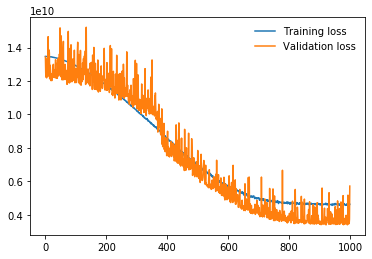

In [32]:
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
cv = cv.split(X_train_scaled, y_train)

m_hidden_layers = 10

n_input = 6
n_hidden = 4
n_output = 1

bs = 64
device = "cuda:0"
epochs = 1000

network_type = "regression"

regressors = []

for fold, (train_idx, val_idx) in enumerate(cv):
    print("Model for Fold: " + str(fold))

    train_set, train_labels = X_train_scaled[train_idx], y_train[train_idx]
    valid_set, valid_labels = X_train_scaled[val_idx], y_train[val_idx]
    
    trainset = HousePriceDataset(train_set, train_labels)
    trainloader = DataLoader(trainset, batch_size = bs, shuffle = True)

    validset = HousePriceDataset(valid_set, valid_labels)
    validloader = DataLoader(validset, batch_size = bs, shuffle = True)

    regressor = NeuralNetwork(m_hidden_layers, n_input, n_hidden, n_output, network_type).to(device)
    criterion = nn.MSELoss()
    criterion_2 = RMSLELoss
    optimizer = optim.Adam(regressor.parameters(), lr = 0.005)
    
    train_losses, test_losses = [], []
    for e in range(epochs):
        running_loss = 0

        for features, labels in trainloader:

            regressor.train()

            features = features.to(device)

            labels = labels.to(device)

            optimizer.zero_grad()

            output = regressor(features.float())

            loss = criterion(output, labels.float())

            loss.backward()

            optimizer.step()

            running_loss += loss.item()

        else:
            test_loss = 0

            with torch.no_grad():
                for features, labels in validloader:
                    regressor.eval()

                    features = features.to(device)
                    labels = labels.to(device)

                    output = regressor(features.float())

                    test_loss += criterion(output, labels)


            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(validloader))

            print("Epoch: {}/{}.. ".format(e+1, epochs),
                  "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
                  "Test Loss: {:.3f}.. ".format(test_loss/len(validloader)))
            
        
        
    plt.plot(train_losses, label='Training loss')
    plt.plot(test_losses, label='Validation loss')
    plt.legend(frameon=False)
    plt.show()
    
    regressors.append(regressor)

# Evaluations with other metrics
- RMSLE Loss and R2 Score
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html

Loss on Testing Data: 4416205312.0
Lets see predictions
[88557.24  88556.914 88557.19  88557.22  88557.234 88557.12  88557.25
 88557.23  88557.24  88557.24  88557.24  88557.805 88557.17  88557.47
 88557.24  88556.98  88557.99  88557.89  88557.875 88557.234 88557.13
 88557.25  88557.15  88557.3   88557.15  88557.234 88557.24  88557.12
 88557.19  88557.25  88557.24  88557.24  88556.99  88555.586 88557.15
 88556.875 88557.06  88557.24  88557.23  88557.21  88556.68  88557.086
 88557.25  88557.22  88557.29  88556.89  88557.23  88557.164 88557.195
 88557.336 88556.914 88557.29  88557.16  88557.234 88557.29  88557.19
 88557.234 88557.23  88557.24  88557.164 88556.98  88557.23  88557.26
 88557.24  88557.18  88556.65  88557.27  88557.7   88557.23  88557.73
 88556.68  88557.19  88557.24  88557.266 88557.33  88557.21  88557.25
 88557.234 88557.12  88557.15  88556.75  88557.24  88557.414 88557.195
 88557.07  88557.17  88557.08  88556.9   88557.25  88557.24  88557.21
 88556.64  88557.055 88557.086 

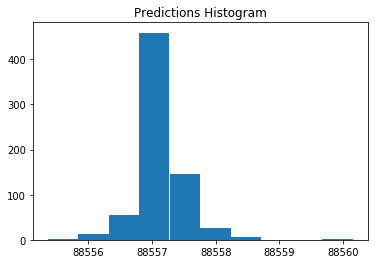

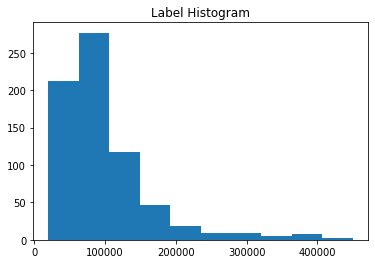

In [33]:
evalset = HousePriceDataset(X_test_scaled, y_test)
loader  = DataLoader(evalset, batch_size=len(X_test_scaled))

with torch.no_grad():
    for features, labels in loader: 
        features = features.to(device)
        labels = labels.to(device)
    
        
        outputs = 0
        for regressor in regressors:
            regressor.eval()
            output = regressor(features.float())
            outputs += output
        
        outputs = outputs / len(models)
        
Ypred = outputs.cpu().numpy().squeeze()
Yreal = labels.cpu().numpy()

print("Loss on Testing Data:", criterion(output, labels).item())

print("Lets see predictions")
print(Ypred)
print(Yreal)

rmsle = RMSLELoss(output, labels)
r2 = r2_score(Yreal, Ypred)

print("R2 Score:", r2)
print("Root Mean Squared Log Error:", rmsle.item())

plt.hist(Ypred)
plt.title("Predictions Histogram")
plt.show()

plt.hist(Yreal)
plt.title("Label Histogram")
plt.show()

# And Sklearn Baseline
# It seems that the problem is still here 
- Even in sklearn if you run multiple runs

Root Mean Squared Log Error Neural Network Sklearn:  1.182376865087882
R2 Score: -1.1300124612395712
[29571.31628032 29571.31628032 29571.31628032 29571.31628032
 29571.31628032 29571.31628032 29571.31628032 29571.31628032
 29571.31628032 29571.31628032 29571.31628032 29571.31628032
 29571.31628032 29571.31628032 29571.31628032 29571.31628032
 29571.31628032 29571.31628032 29571.31628032 29571.31628032
 29571.31628032 29571.31628032 29571.31628032 29571.31628032
 29571.31628032 29571.31628032 29571.31628032 29571.31628032
 29571.31628032 29571.31628032 29571.31628032 29571.31628032
 29571.31628032 29571.31628032 29571.31628032 29571.31628032
 29571.31628032 29571.31628032 29571.31628032 29571.31628032
 29571.31628032 29571.31628032 29571.31628032 29571.31628032
 29571.31628032 29571.31628032 29571.31628032 29571.31628032
 29571.31628032 29571.31628032 29571.31628032 29571.31628032
 29571.31628032 29571.31628032 29571.31628032 29571.31628032
 29571.31628032 29571.31628032 29571.31628032

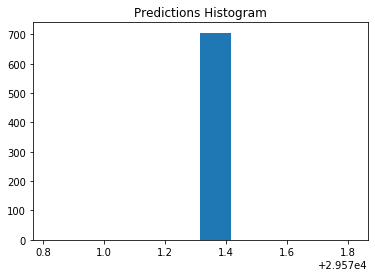

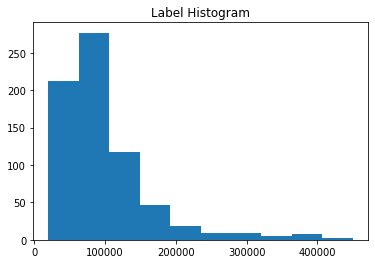

In [34]:
model = MLPRegressor(hidden_layer_sizes = (4, 4, 4, 4, 4, 4, 4, 4, 4), max_iter = 1000)

model.fit(X_train_scaled, y_train)

y_predict = model.predict(X_test_scaled)

print("Root Mean Squared Log Error Neural Network Sklearn: ", RMSLELoss_for_numpy(y_predict, y_test))

r2 = r2_score(y_test, y_predict)
print("R2 Score:", r2)


print(y_predict)

plt.hist(y_predict)
plt.title("Predictions Histogram")
plt.show()

plt.hist(y_test)
plt.title("Label Histogram")
plt.show()

# This solution for this problem would be to scale the labels
- This will help with the convergence, because the initial predictions won't be "to far off"
- And if the targets will be too big, the mean squared error will be huge which means that the gradients will also be huge which can lead to numerical instabiliy.

In [35]:
y_train = np.reshape(y_train, (-1, 1))
y_test = np.reshape(y_test, (-1, 1))

y_train_scaled, y_test_scaled, min_max_scaler = preprocessing(y_train, y_test, preprocessing_type = "MinMax")

# Let's try again in Sklearn

Root Mean Squared Log Error Neural Network Sklearn:  11.210874164524583
R2 Score: 0.7715970780185892
Predictions:  [ 62889.02721158 127210.37665811  52859.79832381  57225.46603787
  49643.40710598  55375.09417938  63361.49429948 187834.55061007
  61136.80522543 140797.26302944  55229.3267905  252392.66938152
  92460.52865064 138590.24007593  59523.97453316 142725.40787546
 260842.76837099 279362.54744955 172002.3707248   52193.10546542
  89299.78297816 113149.81318837  73639.01755216 140013.20813906
  79764.68637618  50035.8768822   52852.66714984  98967.32543539
  57965.97818425  79953.39751684  58408.89470331  47891.49015006
 128314.80355192 115966.47391621 103126.79612956  58606.18499108
  87234.12171066  51001.47175674  61739.55834883  59640.7501331
  58816.0734532  144172.8487026   66724.25071512  63073.34536027
  66379.77745827  88359.71384758  70561.25228717  60642.16200297
 107019.46348747 188890.16279643  90288.46268257  90528.66324515
 112110.24417104  50252.82306892 115761.6

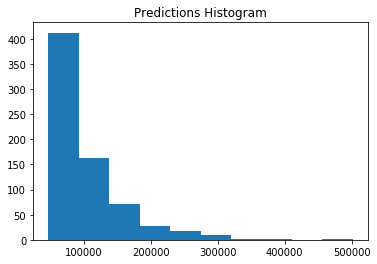

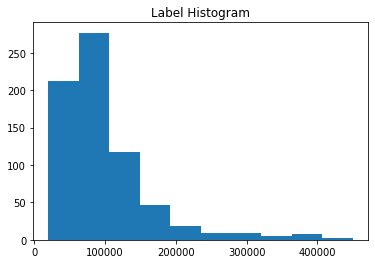

In [36]:
model = MLPRegressor(hidden_layer_sizes = (4, 4, 4, 4, 4, 4, 4, 4), max_iter = 1000)

model.fit(X_train_scaled, y_train_scaled)

y_predict = model.predict(X_test_scaled)
y_predict = np.reshape(y_predict, (-1, 1))

print("Root Mean Squared Log Error Neural Network Sklearn: ", RMSLELoss_for_numpy(y_predict, y_test))

y_predict = min_max_scaler.inverse_transform(y_predict)

r2 = r2_score(y_test, y_predict)
print("R2 Score:", r2)


print("Predictions: ", y_predict.reshape(-1))

plt.hist(y_predict)
plt.title("Predictions Histogram")
plt.show()

plt.hist(y_test)
plt.title("Label Histogram")
plt.show()

# And now back in Pytorch

Model for Fold: 0
Epoch: 1/500..  Training Loss: 0.356..  Test Loss: 0.221.. 
Epoch: 2/500..  Training Loss: 0.259..  Test Loss: 0.168.. 
Epoch: 3/500..  Training Loss: 0.200..  Test Loss: 0.127.. 
Epoch: 4/500..  Training Loss: 0.170..  Test Loss: 0.088.. 
Epoch: 5/500..  Training Loss: 0.147..  Test Loss: 0.083.. 
Epoch: 6/500..  Training Loss: 0.121..  Test Loss: 0.052.. 
Epoch: 7/500..  Training Loss: 0.116..  Test Loss: 0.081.. 
Epoch: 8/500..  Training Loss: 0.095..  Test Loss: 0.052.. 
Epoch: 9/500..  Training Loss: 0.091..  Test Loss: 0.047.. 
Epoch: 10/500..  Training Loss: 0.080..  Test Loss: 0.039.. 
Epoch: 11/500..  Training Loss: 0.073..  Test Loss: 0.039.. 
Epoch: 12/500..  Training Loss: 0.074..  Test Loss: 0.033.. 
Epoch: 13/500..  Training Loss: 0.068..  Test Loss: 0.025.. 
Epoch: 14/500..  Training Loss: 0.064..  Test Loss: 0.027.. 
Epoch: 15/500..  Training Loss: 0.058..  Test Loss: 0.030.. 
Epoch: 16/500..  Training Loss: 0.055..  Test Loss: 0.027.. 
Epoch: 17/500..

Epoch: 136/500..  Training Loss: 0.017..  Test Loss: 0.016.. 
Epoch: 137/500..  Training Loss: 0.017..  Test Loss: 0.018.. 
Epoch: 138/500..  Training Loss: 0.017..  Test Loss: 0.021.. 
Epoch: 139/500..  Training Loss: 0.016..  Test Loss: 0.016.. 
Epoch: 140/500..  Training Loss: 0.017..  Test Loss: 0.015.. 
Epoch: 141/500..  Training Loss: 0.016..  Test Loss: 0.018.. 
Epoch: 142/500..  Training Loss: 0.016..  Test Loss: 0.016.. 
Epoch: 143/500..  Training Loss: 0.017..  Test Loss: 0.021.. 
Epoch: 144/500..  Training Loss: 0.016..  Test Loss: 0.015.. 
Epoch: 145/500..  Training Loss: 0.017..  Test Loss: 0.018.. 
Epoch: 146/500..  Training Loss: 0.017..  Test Loss: 0.013.. 
Epoch: 147/500..  Training Loss: 0.017..  Test Loss: 0.016.. 
Epoch: 148/500..  Training Loss: 0.016..  Test Loss: 0.016.. 
Epoch: 149/500..  Training Loss: 0.017..  Test Loss: 0.015.. 
Epoch: 150/500..  Training Loss: 0.016..  Test Loss: 0.014.. 
Epoch: 151/500..  Training Loss: 0.016..  Test Loss: 0.017.. 
Epoch: 1

Epoch: 272/500..  Training Loss: 0.015..  Test Loss: 0.012.. 
Epoch: 273/500..  Training Loss: 0.015..  Test Loss: 0.012.. 
Epoch: 274/500..  Training Loss: 0.015..  Test Loss: 0.014.. 
Epoch: 275/500..  Training Loss: 0.015..  Test Loss: 0.012.. 
Epoch: 276/500..  Training Loss: 0.014..  Test Loss: 0.017.. 
Epoch: 277/500..  Training Loss: 0.015..  Test Loss: 0.011.. 
Epoch: 278/500..  Training Loss: 0.015..  Test Loss: 0.014.. 
Epoch: 279/500..  Training Loss: 0.015..  Test Loss: 0.013.. 
Epoch: 280/500..  Training Loss: 0.015..  Test Loss: 0.016.. 
Epoch: 281/500..  Training Loss: 0.015..  Test Loss: 0.014.. 
Epoch: 282/500..  Training Loss: 0.015..  Test Loss: 0.015.. 
Epoch: 283/500..  Training Loss: 0.015..  Test Loss: 0.012.. 
Epoch: 284/500..  Training Loss: 0.015..  Test Loss: 0.016.. 
Epoch: 285/500..  Training Loss: 0.015..  Test Loss: 0.014.. 
Epoch: 286/500..  Training Loss: 0.015..  Test Loss: 0.014.. 
Epoch: 287/500..  Training Loss: 0.015..  Test Loss: 0.013.. 
Epoch: 2

Epoch: 408/500..  Training Loss: 0.014..  Test Loss: 0.013.. 
Epoch: 409/500..  Training Loss: 0.014..  Test Loss: 0.013.. 
Epoch: 410/500..  Training Loss: 0.014..  Test Loss: 0.016.. 
Epoch: 411/500..  Training Loss: 0.015..  Test Loss: 0.015.. 
Epoch: 412/500..  Training Loss: 0.013..  Test Loss: 0.012.. 
Epoch: 413/500..  Training Loss: 0.013..  Test Loss: 0.013.. 
Epoch: 414/500..  Training Loss: 0.014..  Test Loss: 0.017.. 
Epoch: 415/500..  Training Loss: 0.014..  Test Loss: 0.013.. 
Epoch: 416/500..  Training Loss: 0.014..  Test Loss: 0.016.. 
Epoch: 417/500..  Training Loss: 0.014..  Test Loss: 0.011.. 
Epoch: 418/500..  Training Loss: 0.015..  Test Loss: 0.018.. 
Epoch: 419/500..  Training Loss: 0.015..  Test Loss: 0.013.. 
Epoch: 420/500..  Training Loss: 0.014..  Test Loss: 0.013.. 
Epoch: 421/500..  Training Loss: 0.014..  Test Loss: 0.012.. 
Epoch: 422/500..  Training Loss: 0.014..  Test Loss: 0.014.. 
Epoch: 423/500..  Training Loss: 0.014..  Test Loss: 0.017.. 
Epoch: 4

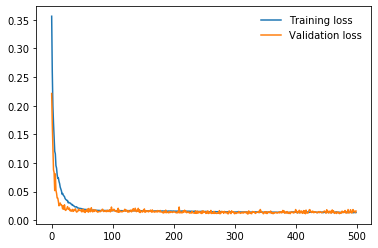

Model for Fold: 1
Epoch: 1/500..  Training Loss: 0.266..  Test Loss: 0.198.. 
Epoch: 2/500..  Training Loss: 0.191..  Test Loss: 0.146.. 
Epoch: 3/500..  Training Loss: 0.134..  Test Loss: 0.090.. 
Epoch: 4/500..  Training Loss: 0.090..  Test Loss: 0.054.. 
Epoch: 5/500..  Training Loss: 0.064..  Test Loss: 0.041.. 
Epoch: 6/500..  Training Loss: 0.043..  Test Loss: 0.036.. 
Epoch: 7/500..  Training Loss: 0.031..  Test Loss: 0.024.. 
Epoch: 8/500..  Training Loss: 0.027..  Test Loss: 0.020.. 
Epoch: 9/500..  Training Loss: 0.024..  Test Loss: 0.022.. 
Epoch: 10/500..  Training Loss: 0.023..  Test Loss: 0.020.. 
Epoch: 11/500..  Training Loss: 0.023..  Test Loss: 0.018.. 
Epoch: 12/500..  Training Loss: 0.021..  Test Loss: 0.017.. 
Epoch: 13/500..  Training Loss: 0.022..  Test Loss: 0.015.. 
Epoch: 14/500..  Training Loss: 0.022..  Test Loss: 0.016.. 
Epoch: 15/500..  Training Loss: 0.021..  Test Loss: 0.018.. 
Epoch: 16/500..  Training Loss: 0.021..  Test Loss: 0.018.. 
Epoch: 17/500..

Epoch: 136/500..  Training Loss: 0.017..  Test Loss: 0.019.. 
Epoch: 137/500..  Training Loss: 0.016..  Test Loss: 0.023.. 
Epoch: 138/500..  Training Loss: 0.016..  Test Loss: 0.017.. 
Epoch: 139/500..  Training Loss: 0.016..  Test Loss: 0.014.. 
Epoch: 140/500..  Training Loss: 0.016..  Test Loss: 0.016.. 
Epoch: 141/500..  Training Loss: 0.017..  Test Loss: 0.018.. 
Epoch: 142/500..  Training Loss: 0.017..  Test Loss: 0.015.. 
Epoch: 143/500..  Training Loss: 0.017..  Test Loss: 0.016.. 
Epoch: 144/500..  Training Loss: 0.016..  Test Loss: 0.016.. 
Epoch: 145/500..  Training Loss: 0.017..  Test Loss: 0.016.. 
Epoch: 146/500..  Training Loss: 0.016..  Test Loss: 0.016.. 
Epoch: 147/500..  Training Loss: 0.016..  Test Loss: 0.017.. 
Epoch: 148/500..  Training Loss: 0.016..  Test Loss: 0.017.. 
Epoch: 149/500..  Training Loss: 0.016..  Test Loss: 0.019.. 
Epoch: 150/500..  Training Loss: 0.016..  Test Loss: 0.016.. 
Epoch: 151/500..  Training Loss: 0.016..  Test Loss: 0.020.. 
Epoch: 1

Epoch: 270/500..  Training Loss: 0.015..  Test Loss: 0.017.. 
Epoch: 271/500..  Training Loss: 0.016..  Test Loss: 0.015.. 
Epoch: 272/500..  Training Loss: 0.017..  Test Loss: 0.015.. 
Epoch: 273/500..  Training Loss: 0.016..  Test Loss: 0.015.. 
Epoch: 274/500..  Training Loss: 0.016..  Test Loss: 0.018.. 
Epoch: 275/500..  Training Loss: 0.015..  Test Loss: 0.014.. 
Epoch: 276/500..  Training Loss: 0.016..  Test Loss: 0.017.. 
Epoch: 277/500..  Training Loss: 0.016..  Test Loss: 0.016.. 
Epoch: 278/500..  Training Loss: 0.015..  Test Loss: 0.015.. 
Epoch: 279/500..  Training Loss: 0.016..  Test Loss: 0.015.. 
Epoch: 280/500..  Training Loss: 0.016..  Test Loss: 0.015.. 
Epoch: 281/500..  Training Loss: 0.015..  Test Loss: 0.014.. 
Epoch: 282/500..  Training Loss: 0.016..  Test Loss: 0.014.. 
Epoch: 283/500..  Training Loss: 0.015..  Test Loss: 0.015.. 
Epoch: 284/500..  Training Loss: 0.016..  Test Loss: 0.014.. 
Epoch: 285/500..  Training Loss: 0.016..  Test Loss: 0.016.. 
Epoch: 2

Epoch: 404/500..  Training Loss: 0.015..  Test Loss: 0.015.. 
Epoch: 405/500..  Training Loss: 0.015..  Test Loss: 0.014.. 
Epoch: 406/500..  Training Loss: 0.015..  Test Loss: 0.014.. 
Epoch: 407/500..  Training Loss: 0.016..  Test Loss: 0.014.. 
Epoch: 408/500..  Training Loss: 0.015..  Test Loss: 0.014.. 
Epoch: 409/500..  Training Loss: 0.015..  Test Loss: 0.012.. 
Epoch: 410/500..  Training Loss: 0.015..  Test Loss: 0.013.. 
Epoch: 411/500..  Training Loss: 0.015..  Test Loss: 0.012.. 
Epoch: 412/500..  Training Loss: 0.016..  Test Loss: 0.016.. 
Epoch: 413/500..  Training Loss: 0.015..  Test Loss: 0.012.. 
Epoch: 414/500..  Training Loss: 0.016..  Test Loss: 0.015.. 
Epoch: 415/500..  Training Loss: 0.015..  Test Loss: 0.017.. 
Epoch: 416/500..  Training Loss: 0.015..  Test Loss: 0.013.. 
Epoch: 417/500..  Training Loss: 0.015..  Test Loss: 0.017.. 
Epoch: 418/500..  Training Loss: 0.015..  Test Loss: 0.014.. 
Epoch: 419/500..  Training Loss: 0.015..  Test Loss: 0.013.. 
Epoch: 4

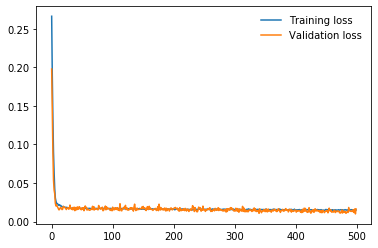

Model for Fold: 2
Epoch: 1/500..  Training Loss: 1.164..  Test Loss: 0.027.. 
Epoch: 2/500..  Training Loss: 0.844..  Test Loss: 0.020.. 
Epoch: 3/500..  Training Loss: 0.555..  Test Loss: 0.020.. 
Epoch: 4/500..  Training Loss: 0.420..  Test Loss: 0.016.. 
Epoch: 5/500..  Training Loss: 0.340..  Test Loss: 0.018.. 
Epoch: 6/500..  Training Loss: 0.205..  Test Loss: 0.018.. 
Epoch: 7/500..  Training Loss: 0.208..  Test Loss: 0.020.. 
Epoch: 8/500..  Training Loss: 0.196..  Test Loss: 0.019.. 
Epoch: 9/500..  Training Loss: 0.159..  Test Loss: 0.019.. 
Epoch: 10/500..  Training Loss: 0.158..  Test Loss: 0.020.. 
Epoch: 11/500..  Training Loss: 0.139..  Test Loss: 0.022.. 
Epoch: 12/500..  Training Loss: 0.109..  Test Loss: 0.019.. 
Epoch: 13/500..  Training Loss: 0.096..  Test Loss: 0.021.. 
Epoch: 14/500..  Training Loss: 0.075..  Test Loss: 0.018.. 
Epoch: 15/500..  Training Loss: 0.079..  Test Loss: 0.019.. 
Epoch: 16/500..  Training Loss: 0.086..  Test Loss: 0.020.. 
Epoch: 17/500..

Epoch: 136/500..  Training Loss: 0.017..  Test Loss: 0.021.. 
Epoch: 137/500..  Training Loss: 0.017..  Test Loss: 0.018.. 
Epoch: 138/500..  Training Loss: 0.017..  Test Loss: 0.015.. 
Epoch: 139/500..  Training Loss: 0.017..  Test Loss: 0.016.. 
Epoch: 140/500..  Training Loss: 0.017..  Test Loss: 0.019.. 
Epoch: 141/500..  Training Loss: 0.017..  Test Loss: 0.016.. 
Epoch: 142/500..  Training Loss: 0.017..  Test Loss: 0.016.. 
Epoch: 143/500..  Training Loss: 0.017..  Test Loss: 0.016.. 
Epoch: 144/500..  Training Loss: 0.017..  Test Loss: 0.017.. 
Epoch: 145/500..  Training Loss: 0.017..  Test Loss: 0.017.. 
Epoch: 146/500..  Training Loss: 0.017..  Test Loss: 0.017.. 
Epoch: 147/500..  Training Loss: 0.017..  Test Loss: 0.019.. 
Epoch: 148/500..  Training Loss: 0.017..  Test Loss: 0.018.. 
Epoch: 149/500..  Training Loss: 0.017..  Test Loss: 0.017.. 
Epoch: 150/500..  Training Loss: 0.017..  Test Loss: 0.014.. 
Epoch: 151/500..  Training Loss: 0.017..  Test Loss: 0.022.. 
Epoch: 1

Epoch: 270/500..  Training Loss: 0.016..  Test Loss: 0.018.. 
Epoch: 271/500..  Training Loss: 0.017..  Test Loss: 0.019.. 
Epoch: 272/500..  Training Loss: 0.017..  Test Loss: 0.016.. 
Epoch: 273/500..  Training Loss: 0.017..  Test Loss: 0.017.. 
Epoch: 274/500..  Training Loss: 0.016..  Test Loss: 0.017.. 
Epoch: 275/500..  Training Loss: 0.016..  Test Loss: 0.017.. 
Epoch: 276/500..  Training Loss: 0.016..  Test Loss: 0.016.. 
Epoch: 277/500..  Training Loss: 0.016..  Test Loss: 0.019.. 
Epoch: 278/500..  Training Loss: 0.017..  Test Loss: 0.017.. 
Epoch: 279/500..  Training Loss: 0.017..  Test Loss: 0.016.. 
Epoch: 280/500..  Training Loss: 0.016..  Test Loss: 0.020.. 
Epoch: 281/500..  Training Loss: 0.017..  Test Loss: 0.021.. 
Epoch: 282/500..  Training Loss: 0.017..  Test Loss: 0.017.. 
Epoch: 283/500..  Training Loss: 0.017..  Test Loss: 0.019.. 
Epoch: 284/500..  Training Loss: 0.016..  Test Loss: 0.019.. 
Epoch: 285/500..  Training Loss: 0.017..  Test Loss: 0.017.. 
Epoch: 2

Epoch: 404/500..  Training Loss: 0.016..  Test Loss: 0.017.. 
Epoch: 405/500..  Training Loss: 0.016..  Test Loss: 0.016.. 
Epoch: 406/500..  Training Loss: 0.016..  Test Loss: 0.015.. 
Epoch: 407/500..  Training Loss: 0.016..  Test Loss: 0.018.. 
Epoch: 408/500..  Training Loss: 0.016..  Test Loss: 0.015.. 
Epoch: 409/500..  Training Loss: 0.016..  Test Loss: 0.015.. 
Epoch: 410/500..  Training Loss: 0.016..  Test Loss: 0.020.. 
Epoch: 411/500..  Training Loss: 0.016..  Test Loss: 0.015.. 
Epoch: 412/500..  Training Loss: 0.016..  Test Loss: 0.017.. 
Epoch: 413/500..  Training Loss: 0.017..  Test Loss: 0.015.. 
Epoch: 414/500..  Training Loss: 0.016..  Test Loss: 0.016.. 
Epoch: 415/500..  Training Loss: 0.016..  Test Loss: 0.017.. 
Epoch: 416/500..  Training Loss: 0.016..  Test Loss: 0.017.. 
Epoch: 417/500..  Training Loss: 0.016..  Test Loss: 0.015.. 
Epoch: 418/500..  Training Loss: 0.016..  Test Loss: 0.016.. 
Epoch: 419/500..  Training Loss: 0.016..  Test Loss: 0.016.. 
Epoch: 4

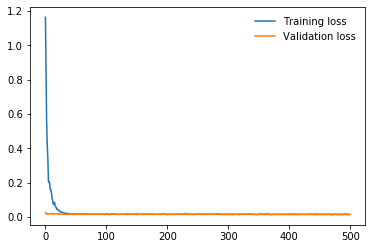

Model for Fold: 3
Epoch: 1/500..  Training Loss: 0.051..  Test Loss: 0.017.. 
Epoch: 2/500..  Training Loss: 0.033..  Test Loss: 0.015.. 
Epoch: 3/500..  Training Loss: 0.032..  Test Loss: 0.017.. 
Epoch: 4/500..  Training Loss: 0.022..  Test Loss: 0.019.. 
Epoch: 5/500..  Training Loss: 0.022..  Test Loss: 0.019.. 
Epoch: 6/500..  Training Loss: 0.021..  Test Loss: 0.018.. 
Epoch: 7/500..  Training Loss: 0.019..  Test Loss: 0.016.. 
Epoch: 8/500..  Training Loss: 0.018..  Test Loss: 0.017.. 
Epoch: 9/500..  Training Loss: 0.018..  Test Loss: 0.028.. 
Epoch: 10/500..  Training Loss: 0.017..  Test Loss: 0.016.. 
Epoch: 11/500..  Training Loss: 0.017..  Test Loss: 0.017.. 
Epoch: 12/500..  Training Loss: 0.016..  Test Loss: 0.017.. 
Epoch: 13/500..  Training Loss: 0.016..  Test Loss: 0.017.. 
Epoch: 14/500..  Training Loss: 0.015..  Test Loss: 0.020.. 
Epoch: 15/500..  Training Loss: 0.016..  Test Loss: 0.016.. 
Epoch: 16/500..  Training Loss: 0.015..  Test Loss: 0.016.. 
Epoch: 17/500..

Epoch: 136/500..  Training Loss: 0.011..  Test Loss: 0.017.. 
Epoch: 137/500..  Training Loss: 0.011..  Test Loss: 0.015.. 
Epoch: 138/500..  Training Loss: 0.011..  Test Loss: 0.015.. 
Epoch: 139/500..  Training Loss: 0.011..  Test Loss: 0.016.. 
Epoch: 140/500..  Training Loss: 0.011..  Test Loss: 0.017.. 
Epoch: 141/500..  Training Loss: 0.011..  Test Loss: 0.014.. 
Epoch: 142/500..  Training Loss: 0.011..  Test Loss: 0.016.. 
Epoch: 143/500..  Training Loss: 0.011..  Test Loss: 0.013.. 
Epoch: 144/500..  Training Loss: 0.010..  Test Loss: 0.018.. 
Epoch: 145/500..  Training Loss: 0.011..  Test Loss: 0.018.. 
Epoch: 146/500..  Training Loss: 0.010..  Test Loss: 0.013.. 
Epoch: 147/500..  Training Loss: 0.011..  Test Loss: 0.013.. 
Epoch: 148/500..  Training Loss: 0.011..  Test Loss: 0.017.. 
Epoch: 149/500..  Training Loss: 0.011..  Test Loss: 0.017.. 
Epoch: 150/500..  Training Loss: 0.011..  Test Loss: 0.013.. 
Epoch: 151/500..  Training Loss: 0.010..  Test Loss: 0.019.. 
Epoch: 1

Epoch: 270/500..  Training Loss: 0.010..  Test Loss: 0.020.. 
Epoch: 271/500..  Training Loss: 0.010..  Test Loss: 0.015.. 
Epoch: 272/500..  Training Loss: 0.010..  Test Loss: 0.015.. 
Epoch: 273/500..  Training Loss: 0.010..  Test Loss: 0.017.. 
Epoch: 274/500..  Training Loss: 0.010..  Test Loss: 0.014.. 
Epoch: 275/500..  Training Loss: 0.010..  Test Loss: 0.018.. 
Epoch: 276/500..  Training Loss: 0.010..  Test Loss: 0.021.. 
Epoch: 277/500..  Training Loss: 0.009..  Test Loss: 0.015.. 
Epoch: 278/500..  Training Loss: 0.010..  Test Loss: 0.014.. 
Epoch: 279/500..  Training Loss: 0.010..  Test Loss: 0.016.. 
Epoch: 280/500..  Training Loss: 0.010..  Test Loss: 0.020.. 
Epoch: 281/500..  Training Loss: 0.010..  Test Loss: 0.015.. 
Epoch: 282/500..  Training Loss: 0.011..  Test Loss: 0.017.. 
Epoch: 283/500..  Training Loss: 0.010..  Test Loss: 0.017.. 
Epoch: 284/500..  Training Loss: 0.010..  Test Loss: 0.016.. 
Epoch: 285/500..  Training Loss: 0.010..  Test Loss: 0.018.. 
Epoch: 2

Epoch: 404/500..  Training Loss: 0.010..  Test Loss: 0.018.. 
Epoch: 405/500..  Training Loss: 0.010..  Test Loss: 0.017.. 
Epoch: 406/500..  Training Loss: 0.010..  Test Loss: 0.016.. 
Epoch: 407/500..  Training Loss: 0.009..  Test Loss: 0.018.. 
Epoch: 408/500..  Training Loss: 0.010..  Test Loss: 0.013.. 
Epoch: 409/500..  Training Loss: 0.011..  Test Loss: 0.014.. 
Epoch: 410/500..  Training Loss: 0.010..  Test Loss: 0.016.. 
Epoch: 411/500..  Training Loss: 0.010..  Test Loss: 0.015.. 
Epoch: 412/500..  Training Loss: 0.009..  Test Loss: 0.022.. 
Epoch: 413/500..  Training Loss: 0.010..  Test Loss: 0.019.. 
Epoch: 414/500..  Training Loss: 0.011..  Test Loss: 0.013.. 
Epoch: 415/500..  Training Loss: 0.009..  Test Loss: 0.016.. 
Epoch: 416/500..  Training Loss: 0.009..  Test Loss: 0.017.. 
Epoch: 417/500..  Training Loss: 0.010..  Test Loss: 0.015.. 
Epoch: 418/500..  Training Loss: 0.010..  Test Loss: 0.017.. 
Epoch: 419/500..  Training Loss: 0.011..  Test Loss: 0.017.. 
Epoch: 4

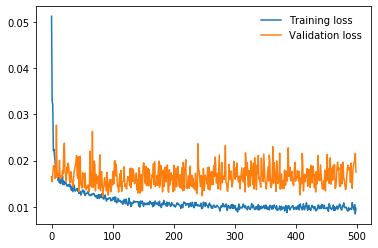

Model for Fold: 4
Epoch: 1/500..  Training Loss: 0.495..  Test Loss: 0.337.. 
Epoch: 2/500..  Training Loss: 0.372..  Test Loss: 0.283.. 
Epoch: 3/500..  Training Loss: 0.260..  Test Loss: 0.206.. 
Epoch: 4/500..  Training Loss: 0.220..  Test Loss: 0.179.. 
Epoch: 5/500..  Training Loss: 0.170..  Test Loss: 0.143.. 
Epoch: 6/500..  Training Loss: 0.141..  Test Loss: 0.129.. 
Epoch: 7/500..  Training Loss: 0.155..  Test Loss: 0.107.. 
Epoch: 8/500..  Training Loss: 0.110..  Test Loss: 0.093.. 
Epoch: 9/500..  Training Loss: 0.086..  Test Loss: 0.089.. 
Epoch: 10/500..  Training Loss: 0.072..  Test Loss: 0.085.. 
Epoch: 11/500..  Training Loss: 0.068..  Test Loss: 0.073.. 
Epoch: 12/500..  Training Loss: 0.059..  Test Loss: 0.061.. 
Epoch: 13/500..  Training Loss: 0.050..  Test Loss: 0.056.. 
Epoch: 14/500..  Training Loss: 0.045..  Test Loss: 0.048.. 
Epoch: 15/500..  Training Loss: 0.041..  Test Loss: 0.046.. 
Epoch: 16/500..  Training Loss: 0.037..  Test Loss: 0.036.. 
Epoch: 17/500..

Epoch: 135/500..  Training Loss: 0.017..  Test Loss: 0.014.. 
Epoch: 136/500..  Training Loss: 0.017..  Test Loss: 0.015.. 
Epoch: 137/500..  Training Loss: 0.017..  Test Loss: 0.019.. 
Epoch: 138/500..  Training Loss: 0.017..  Test Loss: 0.018.. 
Epoch: 139/500..  Training Loss: 0.017..  Test Loss: 0.019.. 
Epoch: 140/500..  Training Loss: 0.017..  Test Loss: 0.016.. 
Epoch: 141/500..  Training Loss: 0.017..  Test Loss: 0.018.. 
Epoch: 142/500..  Training Loss: 0.017..  Test Loss: 0.017.. 
Epoch: 143/500..  Training Loss: 0.017..  Test Loss: 0.015.. 
Epoch: 144/500..  Training Loss: 0.017..  Test Loss: 0.014.. 
Epoch: 145/500..  Training Loss: 0.017..  Test Loss: 0.016.. 
Epoch: 146/500..  Training Loss: 0.017..  Test Loss: 0.014.. 
Epoch: 147/500..  Training Loss: 0.017..  Test Loss: 0.017.. 
Epoch: 148/500..  Training Loss: 0.017..  Test Loss: 0.016.. 
Epoch: 149/500..  Training Loss: 0.017..  Test Loss: 0.015.. 
Epoch: 150/500..  Training Loss: 0.017..  Test Loss: 0.016.. 
Epoch: 1

Epoch: 269/500..  Training Loss: 0.017..  Test Loss: 0.015.. 
Epoch: 270/500..  Training Loss: 0.017..  Test Loss: 0.017.. 
Epoch: 271/500..  Training Loss: 0.017..  Test Loss: 0.018.. 
Epoch: 272/500..  Training Loss: 0.017..  Test Loss: 0.015.. 
Epoch: 273/500..  Training Loss: 0.017..  Test Loss: 0.015.. 
Epoch: 274/500..  Training Loss: 0.017..  Test Loss: 0.016.. 
Epoch: 275/500..  Training Loss: 0.017..  Test Loss: 0.016.. 
Epoch: 276/500..  Training Loss: 0.017..  Test Loss: 0.014.. 
Epoch: 277/500..  Training Loss: 0.017..  Test Loss: 0.015.. 
Epoch: 278/500..  Training Loss: 0.017..  Test Loss: 0.017.. 
Epoch: 279/500..  Training Loss: 0.017..  Test Loss: 0.016.. 
Epoch: 280/500..  Training Loss: 0.017..  Test Loss: 0.015.. 
Epoch: 281/500..  Training Loss: 0.017..  Test Loss: 0.014.. 
Epoch: 282/500..  Training Loss: 0.017..  Test Loss: 0.016.. 
Epoch: 283/500..  Training Loss: 0.017..  Test Loss: 0.018.. 
Epoch: 284/500..  Training Loss: 0.017..  Test Loss: 0.018.. 
Epoch: 2

Epoch: 403/500..  Training Loss: 0.017..  Test Loss: 0.017.. 
Epoch: 404/500..  Training Loss: 0.017..  Test Loss: 0.015.. 
Epoch: 405/500..  Training Loss: 0.017..  Test Loss: 0.015.. 
Epoch: 406/500..  Training Loss: 0.017..  Test Loss: 0.017.. 
Epoch: 407/500..  Training Loss: 0.017..  Test Loss: 0.018.. 
Epoch: 408/500..  Training Loss: 0.017..  Test Loss: 0.014.. 
Epoch: 409/500..  Training Loss: 0.017..  Test Loss: 0.017.. 
Epoch: 410/500..  Training Loss: 0.017..  Test Loss: 0.016.. 
Epoch: 411/500..  Training Loss: 0.017..  Test Loss: 0.016.. 
Epoch: 412/500..  Training Loss: 0.017..  Test Loss: 0.015.. 
Epoch: 413/500..  Training Loss: 0.017..  Test Loss: 0.016.. 
Epoch: 414/500..  Training Loss: 0.017..  Test Loss: 0.015.. 
Epoch: 415/500..  Training Loss: 0.017..  Test Loss: 0.016.. 
Epoch: 416/500..  Training Loss: 0.017..  Test Loss: 0.015.. 
Epoch: 417/500..  Training Loss: 0.017..  Test Loss: 0.014.. 
Epoch: 418/500..  Training Loss: 0.017..  Test Loss: 0.014.. 
Epoch: 4

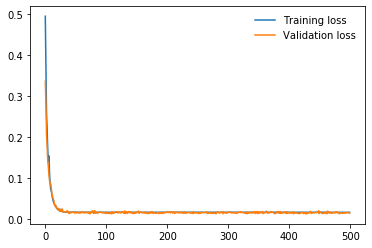

In [37]:
cv = KFold(n_splits = 5, shuffle = True, random_state = 42)
cv = cv.split(X_train_scaled, y_train_scaled)

m_hidden_layers = 10

n_input = 6
n_hidden = 4
n_output = 1

bs = 256
device = "cuda:0"
epochs = 500

network_type = "regression"

regressors = []

for fold, (train_idx, val_idx) in enumerate(cv):
    print("Model for Fold: " + str(fold))

    train_set, train_labels = X_train_scaled[train_idx], y_train_scaled[train_idx]
    valid_set, valid_labels = X_train_scaled[val_idx], y_train_scaled[val_idx]
    
    trainset = HousePriceDataset(train_set, train_labels)
    trainloader = DataLoader(trainset, batch_size = bs, shuffle = True)

    validset = HousePriceDataset(valid_set, valid_labels)
    validloader = DataLoader(validset, batch_size = bs, shuffle = True)

    regressor = NeuralNetwork(m_hidden_layers, n_input, n_hidden, n_output, network_type).to(device)
    criterion = nn.MSELoss()
    criterion_2 = RMSLELoss
    optimizer = optim.Adam(regressor.parameters(), lr = 0.003)
    
    train_losses, test_losses = [], []
    for e in range(epochs):
        running_loss = 0

        for features, labels in trainloader:

            regressor.train()

            features = features.to(device)

            labels = labels.to(device)

            optimizer.zero_grad()

            output = regressor(features.float())

            loss = criterion(output, labels.float())

            loss.backward()

            optimizer.step()

            running_loss += loss.item()

        else:
            test_loss = 0

            with torch.no_grad():
                for features, labels in validloader:
                    regressor.eval()

                    features = features.to(device)
                    labels = labels.to(device)

                    output = regressor(features.float())

                    test_loss += criterion(output, labels)


            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(validloader))

            print("Epoch: {}/{}.. ".format(e+1, epochs),
                  "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
                  "Test Loss: {:.3f}.. ".format(test_loss/len(validloader)))
            
        
        
    plt.plot(train_losses, label='Training loss')
    plt.plot(test_losses, label='Validation loss')
    plt.legend(frameon=False)
    plt.show()
    
    regressors.append(regressor)

Lets see predictions
[ 84137.8    94764.68   91239.1    83861.56   84068.85   87937.305
  84173.484  99618.8    84058.19   97120.805  84870.62  102794.19
  94315.62   98489.08   84943.54   96062.95  103825.86  104198.016
 100936.516  84090.5    94301.1    95313.34   84361.17   97668.48
  88891.37   83982.484  84348.95   94439.04   91063.21   90551.305
  84999.234  83950.55   96218.445  84908.59   94559.02   85162.12
  94373.87   84552.31   84155.09   90709.93   85056.875  96730.36
  84182.62   84096.055  91246.86   91271.22   90558.836  84706.516
  94563.16  100485.31   94249.03   94359.91   94695.2    84289.08
  94755.08   94525.83   84346.43   84108.125  84939.23   88058.91
  84271.63   95771.47   90762.94   84847.28   84254.46   97727.69
  94349.37   97817.086  84099.9   101920.836  97636.48   95966.734
  85493.74   96766.69   91155.086  96249.93   94732.086  83963.68
  91078.336  94144.16   84690.92   84160.11   94006.88   88019.234
  94479.93   85438.62   99937.24   98159.766  841

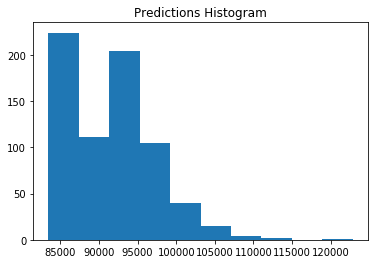

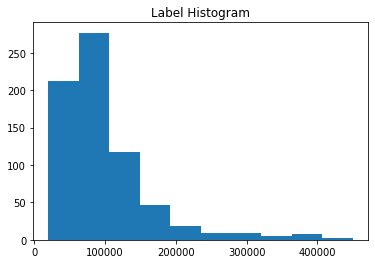

In [38]:
evalset = HousePriceDataset(X_test_scaled, y_test)
loader  = DataLoader(evalset, batch_size = len(X_test_scaled))
 
with torch.no_grad():
    for features, labels in loader: 
        features = features.to(device)
        labels = labels.to(device)
        
        outputs = 0
        for regressor in regressors:
            regressor.eval()
            output = regressor(features.float())
            outputs += output
        
        outputs = outputs / len(models)
        
Ypred = outputs.cpu().numpy()

Ypred = min_max_scaler.inverse_transform(Ypred)

Yreal = labels.cpu().numpy()

# print("Loss on Testing Data:", criterion(output, labels).item())

print("Lets see predictions")
print(Ypred.reshape(-1))
print(Yreal.reshape(-1))

rmsle = RMSLELoss(output, labels)
r2 = r2_score(Yreal, Ypred)

print("R2 Score:", r2)
print("Root Mean Squared Log Error:", rmsle.item())

plt.hist(Ypred)
plt.title("Predictions Histogram")
plt.show()

plt.hist(Yreal)
plt.title("Label Histogram")
plt.show()

# This could use some fine-tuning, but for now we solved the predictions problem

# Ideas for improvements
- Bayesion Optimization for neural network parameters (num_layers, num_neurons, etc.)
- Meta-Models for the regresion part, with stacking or blending methodology
- Other type of date preprocessing and feature extraction